In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd
import seaborn as sns # Будем визулизировать данные этой библиотекой
import pandas as pd # Библиотека для работы с датафреймом
import numpy as np # Библиотека для работы с массивами
import matplotlib.pyplot as plt # Будем визулизировать данные этой библиотекой
sns.set_style('darkgrid')
from sklearn.preprocessing import StandardScaler # Масштабирование данных

In [3]:
from tensorflow.keras import utils # Функции-утилиты для работы с категориальными данными
from tensorflow.keras.models import Sequential, Model # Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, Input, concatenate # Основные слои
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D # Основные слои
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop, Nadam # Оптимизаторы
import re # Регулярные выражения
from sklearn.metrics import mean_squared_error, mean_absolute_error # Метрики для расчета ошибок
from sklearn.model_selection import train_test_split

In [4]:
from keras.models import load_model

In [5]:
import re
from tabulate import tabulate

##Подключение баз.

In [ ]:
df1 = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Скоринг/db0.csv')# таблица по хорошим клиентам
df1.shape

<ipython-input-6-15c6280923ac>:1: DtypeWarning: Columns (15,31,33,37,40) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Скоринг/db0.csv')# таблица по хорошим клиентам


(408262, 42)

In [ ]:
df2 = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Скоринг/db1-1.csv')# таблица 2 класс
df2.shape

<ipython-input-7-571be7c0d01a>:1: DtypeWarning: Columns (31,33,38) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Скоринг/db1-1.csv')# таблица 2 класс


(1376371, 42)

In [ ]:
df3 = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Скоринг/db2-1.csv')# таблица 3 класс
df3.shape


(585178, 42)

In [ ]:
df4 = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Скоринг/db3-1.csv')# таблица по плохим клиентам
df4.shape

<ipython-input-9-381d227046b2>:1: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  df4 = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Скоринг/db3-1.csv')# таблица по плохим клиентам


(872741, 42)

#Деление на 2 базы 1+2 и 3+4

In [ ]:
db12 = pd.concat((df1, df2))
db12.shape

(1784633, 42)

In [ ]:
db12['Client_class'] = db12['Client_class'].replace(1, 0)

In [ ]:
db34 = pd.concat((df3, df4))
db34.shape

(1457919, 42)

In [ ]:
db34['Client_class'] = 1

In [ ]:
#объединим в одну базу
db_2cl = pd.concat((db12, db34))
db_2cl.shape

(3242552, 42)

##Объединение в общую

In [ ]:
db = pd.concat((df1, df2, df3, df4))
db.shape

(3242552, 42)

##Очистка столбцов


In [ ]:
db.shape

(3242552, 42)

In [ ]:
db.isna().sum().sum() # количество пустых значений очень большое, нужно чистить.

9587551

region_name                              0.0
city_name                                0.0
population                               0.0
date of birth                            0.0
gender                                   0.0
education                               16.0
position                                 4.0
dt_nbki                                  0.0
id_nbki                                  0.0
issued                                   0.0
amount                                   0.0
currency                                 0.0
type_credit                              0.0
status_credit                            0.0
period                                   0.0
period_interest                         16.0
psk                                      0.0
balance                                  0.0
current_indebtedness                     0.0
expired                                  0.0
days_overdue                            30.0
next_payment                             0.0
last_payme

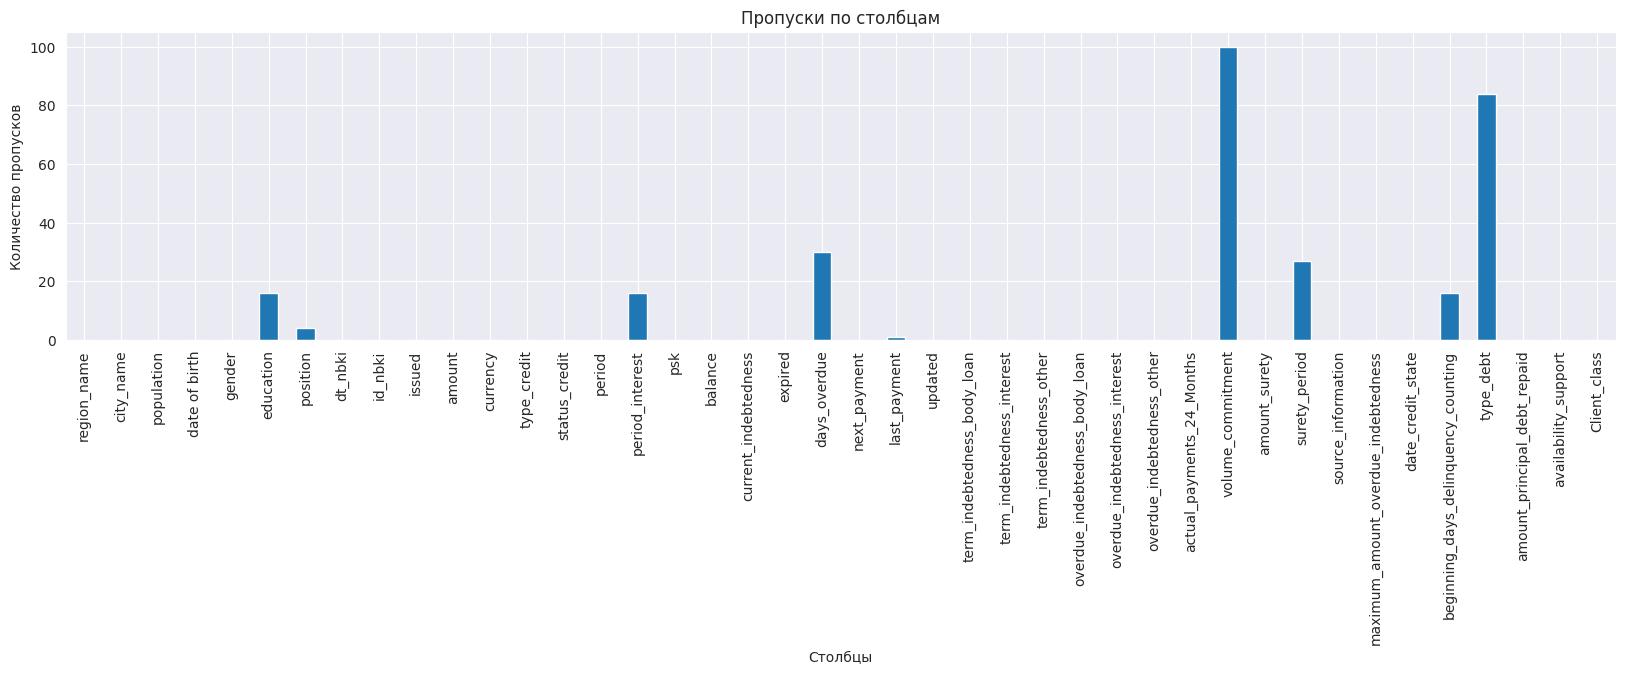

In [ ]:
missing_percentages = round(db.isnull().mean() * 100)
print(missing_percentages)

# Отрисовываем график
plt.figure(figsize=(20, 4))
missing_percentages.plot(kind='bar')
plt.title('Пропуски по столбцам')
plt.xlabel('Столбцы')
plt.ylabel('Количество пропусков')
plt.show()

In [ ]:
# Определяем столбцы с пропусками выше 51%
columns_to_drop = missing_percentages[missing_percentages > 51].index

# Удаляем выбранные столбцы из DataFrame
db = db.drop(columns=columns_to_drop)

In [ ]:
print(columns_to_drop)# удаленные столбцы с количеством пропусков более 51%

Index(['volume_commitment', 'type_debt'], dtype='object')


In [ ]:
db.isna().sum().sum()# количество пустых значений уменьшилось.

3611405

In [ ]:
db["dt_nbki"].unique()

array(['2023-03-05', '2023-03-04', '2023-04-20', ...,
       '2022-10-29 00:00:00', '2022-10-27 00:00:00',
       '2023-01-02 00:00:00'], dtype=object)

In [ ]:
# Преобразование столбца 'dt_nbki' в тип данных datetime, если он еще не является datetime
db['dt_nbki'] = pd.to_datetime(db['dt_nbki'])
db = db[db['dt_nbki'].dt.year >=  2021]#обрезаем по 2021 году

In [ ]:
#еще раз проверим по распределению пустых значений
#дропнем столбцы которые были удалены ранее и модель набрала 91%
db = db.drop(columns= {'period_interest', 'days_overdue', 'surety_period', 'beginning_days_delinquency_counting'})

#Перевод данных типа объект в категории

In [ ]:
obj_db = db.select_dtypes(include=['object']).copy()

In [ ]:
obj_db.dtypes

region_name             object
city_name               object
date of birth           object
gender                  object
education               object
position                object
id_nbki                 object
issued                  object
currency                object
type_credit             object
status_credit           object
period                  object
last_payment            object
updated                 object
source_information      object
date_credit_state       object
availability_support    object
dtype: object

In [ ]:
db = db.dropna (subset=['region_name'])
db['region_name'].isnull().mean()*100

0.0

In [ ]:
db["region_name"] = db["region_name"].astype('category')
db["region_name"] = db["region_name"].cat.codes

In [ ]:
db['city_name'].isnull().mean()*100

0.0

In [ ]:
db["city_name"] = db["city_name"].astype('category')
db["city_name"] = db["city_name"].cat.codes

In [ ]:
db['date of birth'].isnull().mean()*100

0.0

In [ ]:
db["date of birth"] = db["date of birth"].astype('category')
db["date of birth"] = db["date of birth"].cat.codes

In [ ]:
db['gender'].isnull().mean()*100

0.0

In [ ]:
db["gender"] = db["gender"].astype('category')
db["gender"] = db["gender"].cat.codes

In [ ]:
# Пустые значения
db['education'] = db['education'].fillna('Неполное')
db['education'].isnull().mean()*100

0.0

In [ ]:
db["education"] = db["education"].astype('category')
db["education"] = db["education"].cat.codes

In [ ]:
# Пустые значения
db['position'] = db['position'].fillna('прочее')
db['position'].isnull().mean()*100

0.0

In [ ]:
db["position"] = db["position"].astype('category')
db["position"] = db["position"].cat.codes

In [ ]:
db['dt_nbki'].isnull().mean()*100

0.0

In [ ]:
db["dt_nbki"] = db["dt_nbki"].astype('category')
db["dt_nbki"] = db["dt_nbki"].cat.codes

In [ ]:
db["dt_nbki"].unique()

array([788, 787, 834, 833, 534, 821, 818, 737, 822, 828, 660, 824, 805,
       739, 845, 825, 826, 793, 738, 840, 722, 480, 820, 829, 740, 847,
       846, 855, 794, 789, 774, 573, 765, 827, 732, 605, 838, 776, 622,
       744, 702, 779, 770, 786, 759, 615, 768, 856, 778, 782, 807, 751,
       831, 716, 851, 630, 667, 712, 785, 810, 843, 832, 524, 814, 858,
       795, 714, 550, 815, 837, 718, 746, 508, 707, 594, 835, 800, 525,
       743, 541, 767, 719, 736, 459, 581, 492, 823, 742, 775, 862, 708,
       781, 803, 623, 764, 791, 808, 483, 849, 755, 705, 670, 761, 692,
       817, 606, 839, 553, 701, 796, 612, 694, 685, 638, 763, 458, 720,
       784, 769, 801, 792, 799, 587, 819, 749, 842, 806, 646, 528, 542,
       798, 836, 771, 643, 729, 659, 699, 797, 844, 777, 652, 790, 625,
       813, 677, 715, 804, 700, 689, 734, 773, 830, 651, 853, 760, 674,
       859, 850, 559, 680, 678, 717, 848, 772, 560, 723, 730, 616, 802,
       642, 650, 748, 857, 812, 696, 698, 691, 735, 676, 668, 44

In [ ]:
db['id_nbki'].isnull().mean()*100

0.0

In [ ]:
db["id_nbki"] = db["id_nbki"].astype('category')
db["id_nbki"] = db["id_nbki"].cat.codes

In [ ]:
db = db.dropna (subset=['issued'])
db['issued'].isnull().mean()*100

0.0

In [ ]:
db["issued"] = db["issued"].astype('category')
db["issued"] = db["issued"].cat.codes

In [ ]:
# Пустые значения
db['type_credit'] = db['type_credit'].fillna('ДругойТипКредита')
db['type_credit'].isnull().mean()*100

0.0

In [ ]:
db["type_credit"] = db["type_credit"].astype('category')
db["type_credit"] = db["type_credit"].cat.codes

In [ ]:
db = db.dropna (subset=['status_credit'])
db['status_credit'].isnull().mean()*100

0.0

In [ ]:
db["status_credit"] = db["status_credit"].astype('category')
db["status_credit"] = db["status_credit"].cat.codes

In [ ]:
db['period'] = db['period'].fillna('2100-01-01')
db['period'].isnull().mean()*100

0.0

In [ ]:
db["period"] = db["period"].astype('category')
db["period"] = db["period"].cat.codes

In [ ]:
# Пустые значения
db['last_payment'] = db['last_payment'].fillna('2017-01-01')
db['last_payment'].isnull().mean()*100

0.0

In [ ]:
db["last_payment"] = db["last_payment"].astype('category')
db["last_payment"] = db["last_payment"].cat.codes

In [ ]:
db['updated'].isnull().mean()*100

0.0

In [ ]:
db["updated"] = db["updated"].astype('category')
db["updated"] = db["updated"].cat.codes

In [ ]:
db['source_information'].isnull().mean()*100

0.0

In [ ]:
db["source_information"] = db["source_information"].astype('category')
db["source_information"] = db["source_information"].cat.codes

In [ ]:
db = db.dropna (subset=['date_credit_state'])
db['date_credit_state'].isnull().mean()*100

0.0

In [ ]:
db["date_credit_state"] = db["date_credit_state"].astype('category')
db["date_credit_state"] = db["date_credit_state"].cat.codes

In [ ]:
db['availability_support'].isnull().mean()*100

0.0

In [ ]:
db["availability_support"] = db["availability_support"].astype('category')
db["availability_support"] = db["availability_support"].cat.codes

In [ ]:
db = db.drop(columns='currency')#удаление столбца валюта

In [ ]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2580048 entries, 0 to 2580047
Data columns (total 35 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   region_name                          int64  
 1   city_name                            int64  
 2   population                           float64
 3   date of birth                        int64  
 4   gender                               int64  
 5   education                            int64  
 6   position                             int64  
 7   dt_nbki                              int64  
 8   id_nbki                              int64  
 9   issued                               int64  
 10  amount                               float64
 11  type_credit                          int64  
 12  status_credit                        int64  
 13  period                               int64  
 14  psk                                  float64
 15  balance                         

In [ ]:
db.to_csv('/content/gdrive/MyDrive/Colab Notebooks/Скоринг/db_4-3_cat_cl2-1.csv', index=False)

#Балансировка классов

In [ ]:
db.agg(['nunique']).transpose()

,nunique
region_name,70
city_name,806
population,802
date of birth,26838
gender,2
education,8
position,23
dt_nbki,905
id_nbki,46219
issued,13238


1    981194
3    742819
2    448171
0    407864
Name: Client_class, dtype: int64


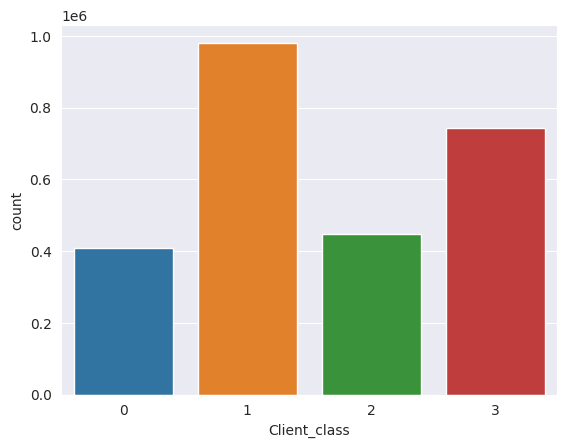

In [ ]:
print(db.Client_class.value_counts())
sns.countplot(x=db.Client_class);

In [ ]:
d1, d4, d2, d3 = db.Client_class.value_counts()

In [ ]:
db1 = db.loc[db.Client_class == 0]
db1['id_nbki'].nunique()

10801

In [ ]:
db2 = db.loc[db.Client_class == 1]
db2['id_nbki'].nunique()

11967

In [ ]:
db2 = db.loc[db.Client_class == 1]
db2 = db2[db2['id_nbki'].isin(db2['id_nbki'].unique()[-430:])]


In [ ]:
db3 = db.loc[db.Client_class == 2]
db3['id_nbki'].nunique()

8518

In [ ]:
db4 = db.loc[db.Client_class == 3]
db4['id_nbki'].nunique()

17408

In [ ]:
db4 = db.loc[db.Client_class == 3]
db4 = db4[db4['id_nbki'].isin(db4['id_nbki'].unique()[-900:])]

In [ ]:
db1.shape, db2.shape, db3.shape, db4.shape

((407864, 35), (40408, 35), (448171, 35), (43583, 35))

In [ ]:
db_bal = pd.concat([db1, db2, db3, db4])

In [ ]:
db_bal.to_csv('/content/gdrive/MyDrive/Colab Notebooks/Скоринг/db_bal_new.csv', index=False)

#Оценка важности данных

In [ ]:
db = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Скоринг/db_bal_new.csv')

In [ ]:
from sklearn.feature_selection import mutual_info_regression

In [ ]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 940026 entries, 0 to 940025
Data columns (total 35 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   region_name                          940026 non-null  int64  
 1   city_name                            940026 non-null  int64  
 2   population                           940026 non-null  float64
 3   date of birth                        940026 non-null  int64  
 4   gender                               940026 non-null  int64  
 5   education                            940026 non-null  int64  
 6   position                             940026 non-null  int64  
 7   dt_nbki                              940026 non-null  int64  
 8   id_nbki                              940026 non-null  int64  
 9   issued                               940026 non-null  int64  
 10  amount                               940026 non-null  float64
 11  type_credit  

In [ ]:
db = db.dropna()

Feature: id_nbki Score: 0.9850011424468654
Feature: date of birth Score: 0.9355030962737665
Feature: dt_nbki Score: 0.6716517581904462
Feature: last_payment Score: 0.6153158487098107
Feature: updated Score: 0.6137307199496966
Feature: date_credit_state Score: 0.6117644738437686
Feature: issued Score: 0.6074151522764488
Feature: amount_principal_debt_repaid Score: 0.3239411901309044
Feature: population Score: 0.2449878098136491
Feature: city_name Score: 0.2442453783210592
Feature: period Score: 0.1994637736219147
Feature: balance Score: 0.15207894458822757
Feature: psk Score: 0.1478702177986726
Feature: amount Score: 0.11674894432703908
Feature: region_name Score: 0.11246107240415171
Feature: education Score: 0.1091251342558257
Feature: actual_payments_24_Months Score: 0.06549835287293426
Feature: position Score: 0.04951066814430405
Feature: current_indebtedness Score: 0.03362795058127066
Feature: maximum_amount_overdue_indebtedness Score: 0.03241437810495462
Feature: availability_suppo

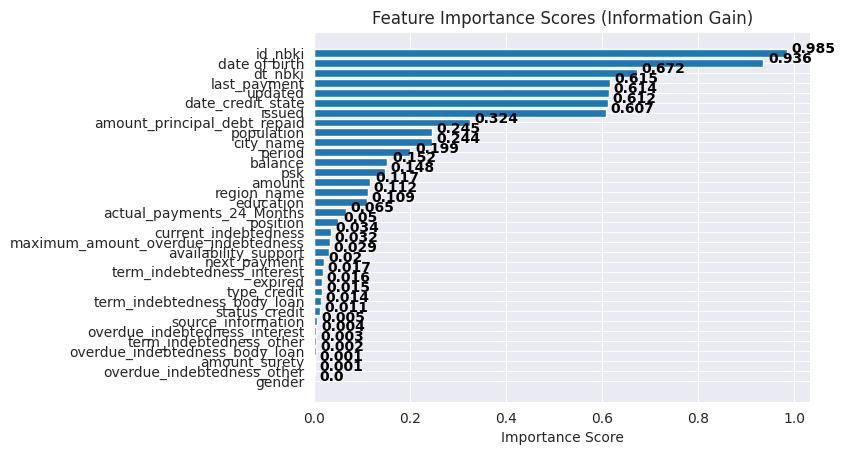

In [ ]:
# Split the dataset into features and target
X = db.drop('Client_class', axis=1)
y = np.array(db['Client_class'])

# Apply Information Gain
ig = mutual_info_regression(X, y)

# Create a dictionary of feature importance scores
feature_scores = {}
for i in range(len(X.columns.values)):
    feature_scores[X.columns.values[i]] = ig[i]
# Sort the features by importance score in descending order
sorted_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)

# Print the feature importance scores and the sorted features
for feature, score in sorted_features:
    print("Feature:", feature, "Score:", score)
# Plot a horizontal bar chart of the feature importance scores
fig, ax = plt.subplots()
y_pos = np.arange(len(sorted_features))
ax.barh(y_pos, [score for feature, score in sorted_features], align="center")
ax.set_yticks(y_pos)
ax.set_yticklabels([feature for feature, score in sorted_features])
ax.invert_yaxis()  # Labels read top-to-bottom
ax.set_xlabel("Importance Score")
ax.set_title("Feature Importance Scores (Information Gain)")

# Add importance scores as labels on the horizontal bar chart
for i, v in enumerate([score for feature, score in sorted_features]):
    ax.text(v + 0.01, i, str(round(v, 3)), color="black", fontweight="bold")
plt.show()

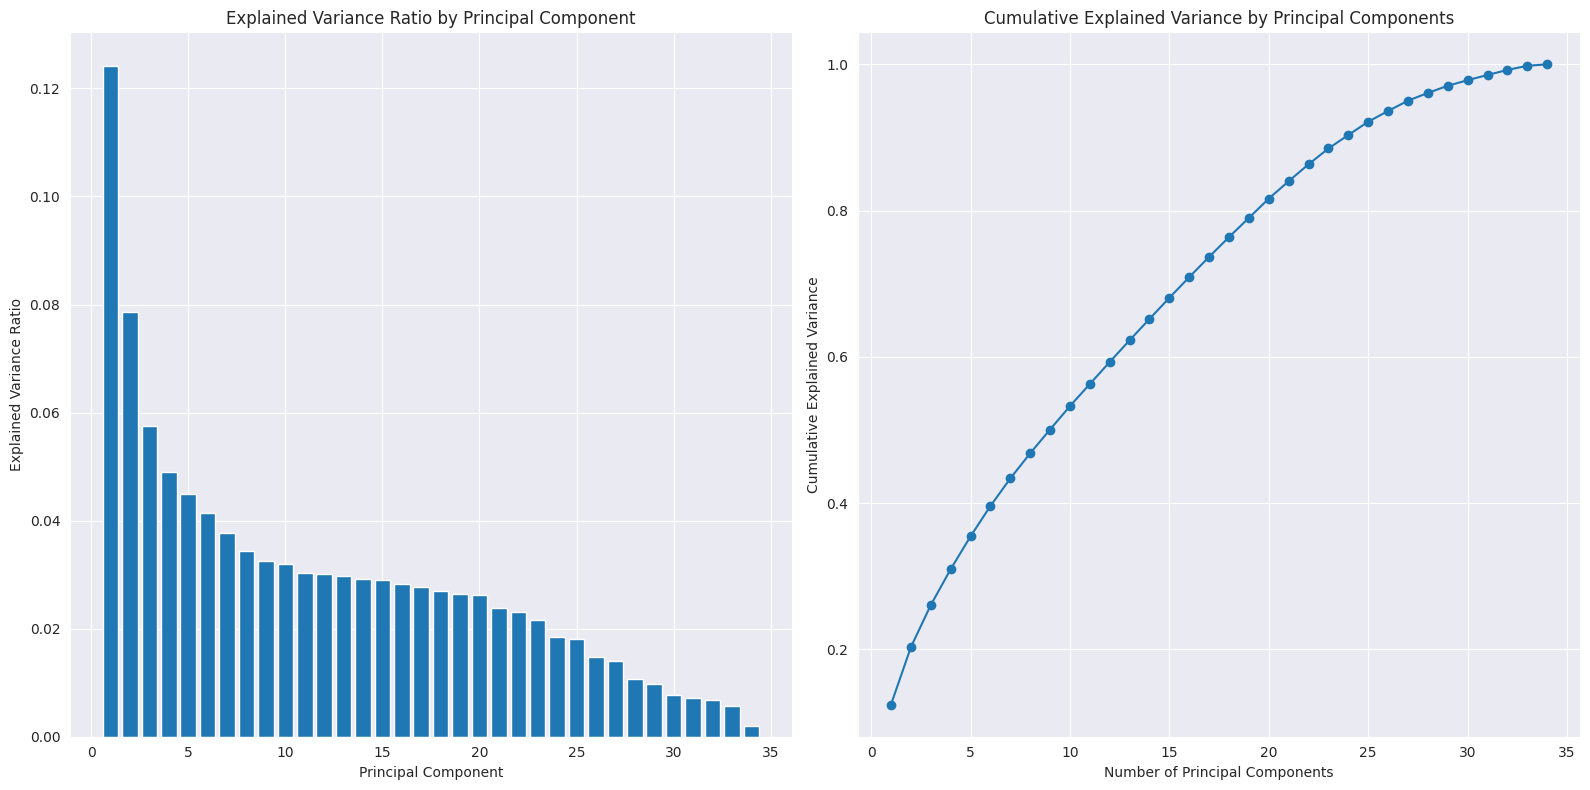

In [ ]:
#PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Calculate the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Create a 2x1 grid of subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# Plot the explained variance ratio in the first subplot
ax1.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
ax1.set_xlabel("Principal Component")
ax1.set_ylabel("Explained Variance Ratio")
ax1.set_title("Explained Variance Ratio by Principal Component")

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot the cumulative explained variance in the second subplot
ax2.plot(
    range(1, len(cumulative_explained_variance) + 1),
    cumulative_explained_variance,
    marker="o",
)
ax2.set_xlabel("Number of Principal Components")
ax2.set_ylabel("Cumulative Explained Variance")
ax2.set_title("Cumulative Explained Variance by Principal Components")

# Display the figure
plt.tight_layout()
plt.show()

## Корреляция

In [ ]:
db = db.reset_index(drop=True)

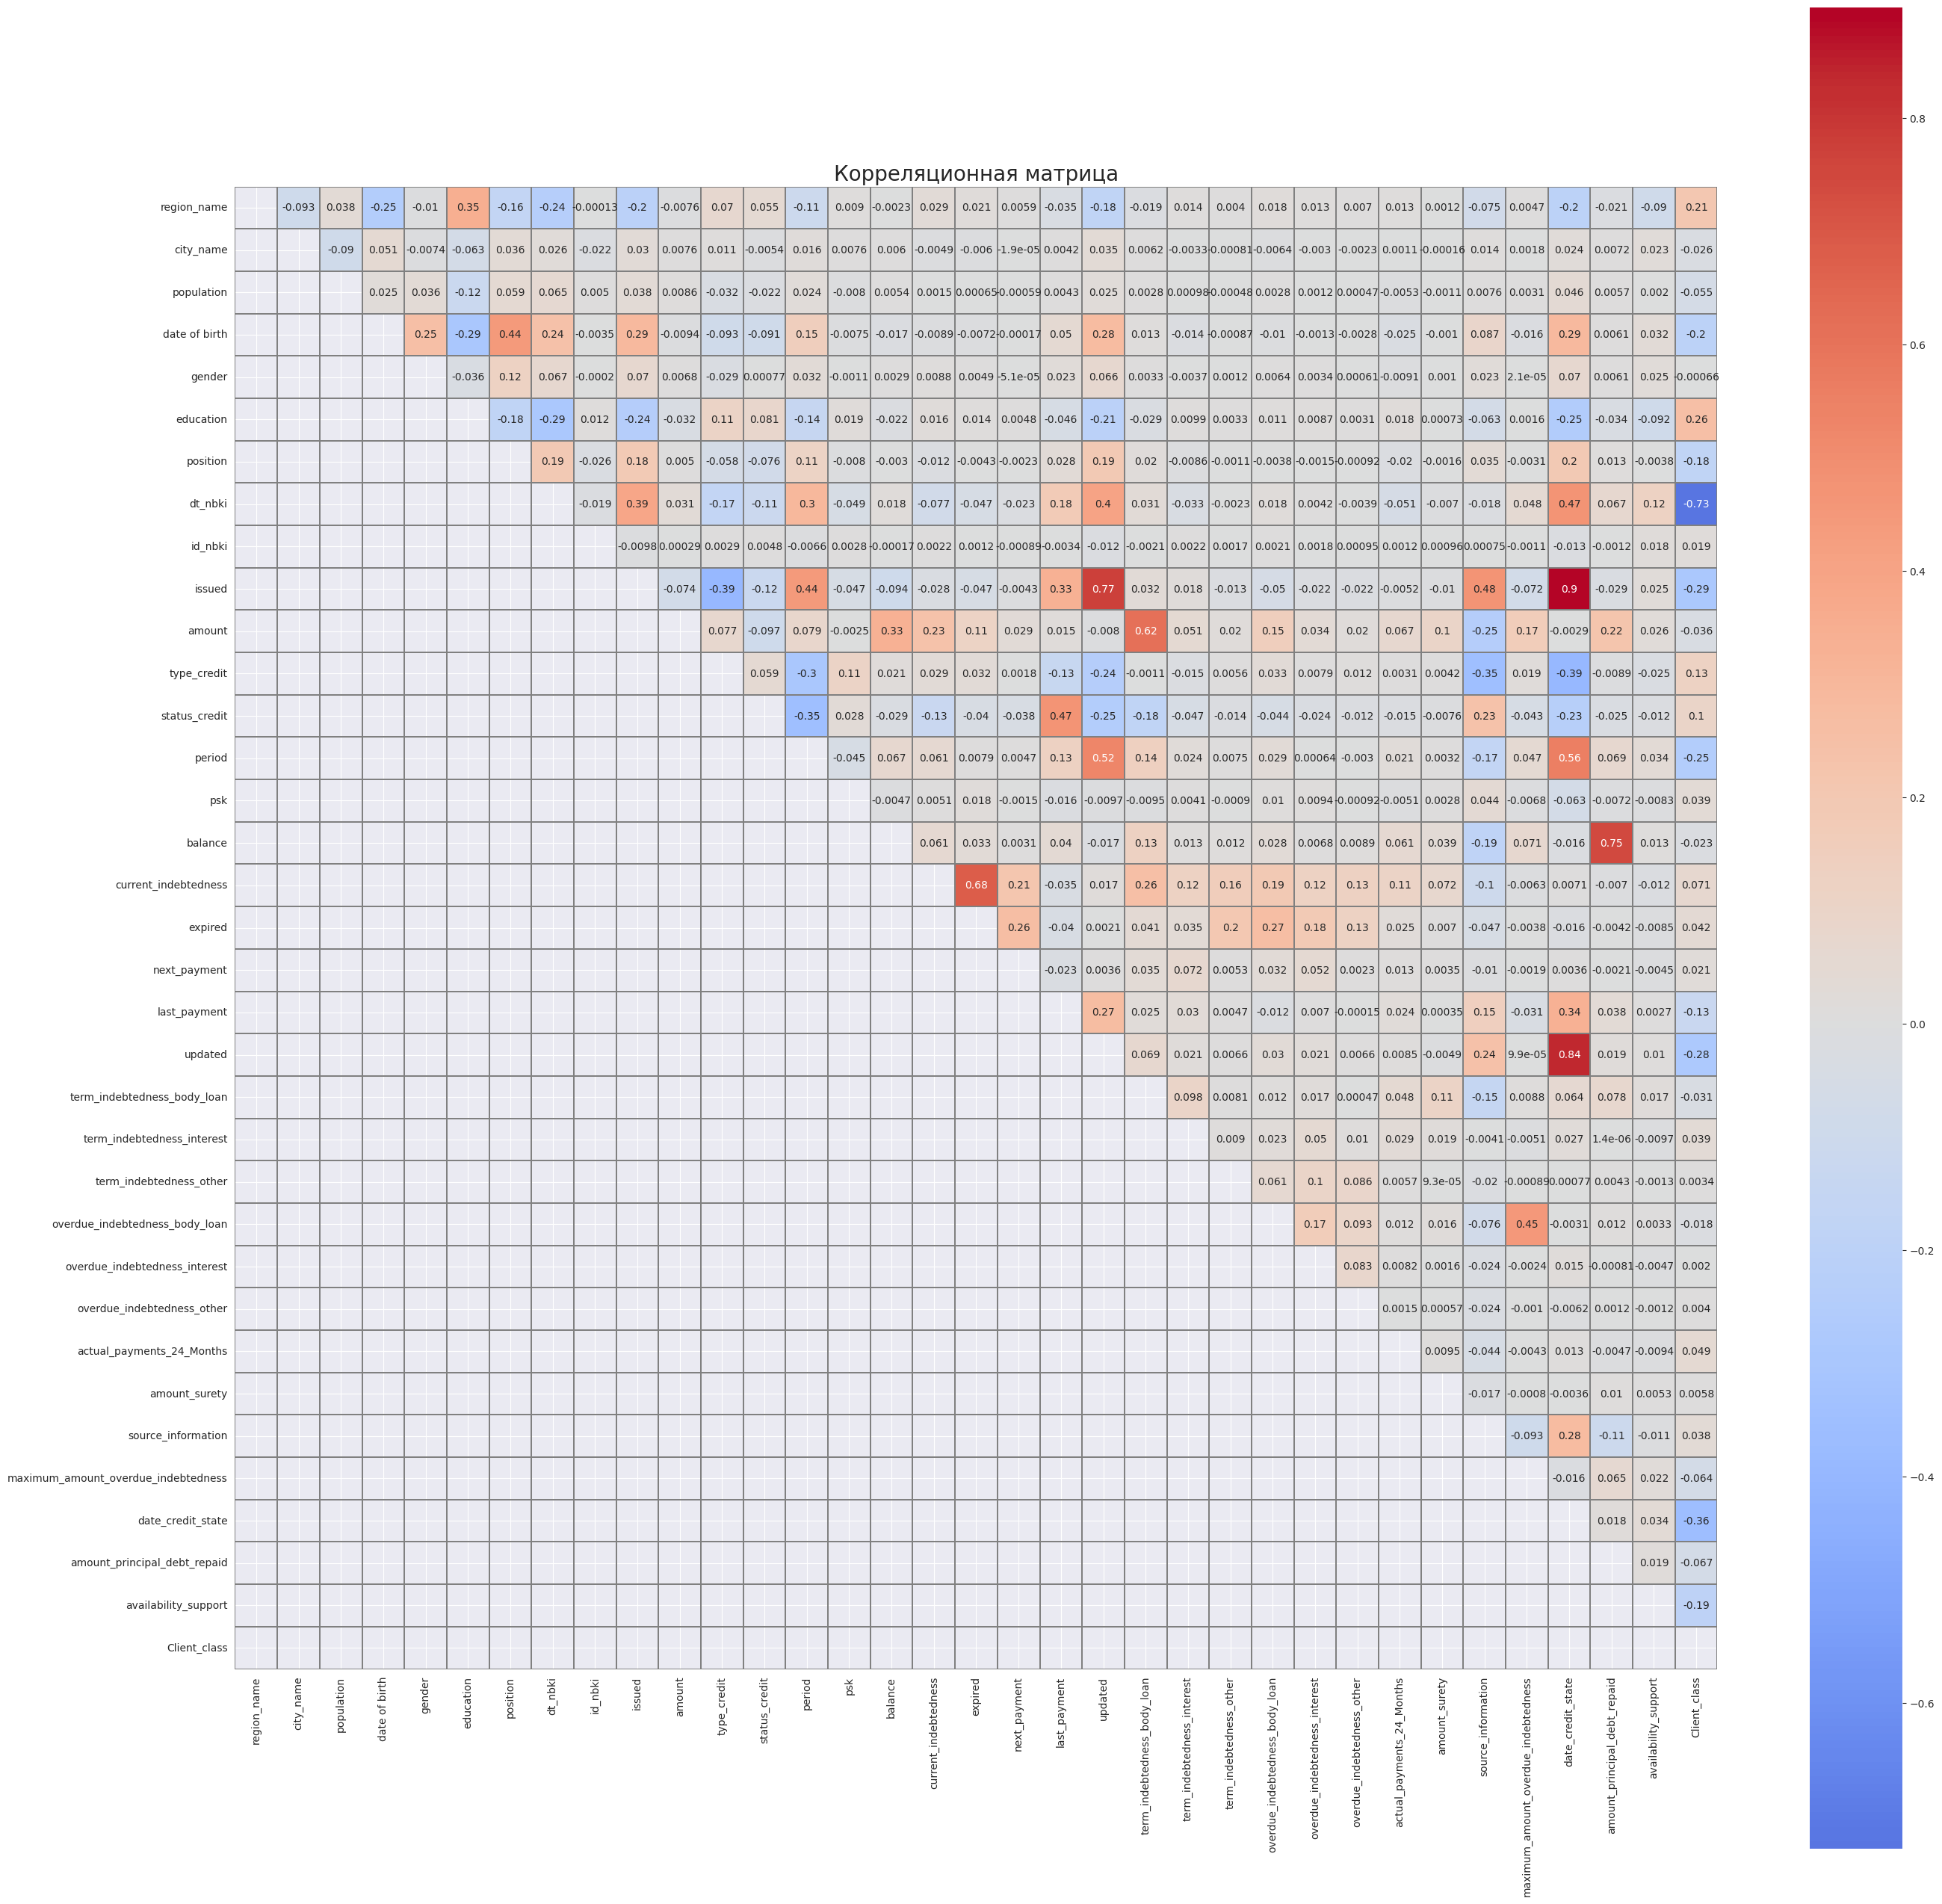

In [ ]:
# Таблица корреляции признаков
mask_1 = np.tril(db.corr())
plt.figure(figsize=(32,32))
sns.heatmap(db.corr(), cmap='coolwarm', center= 0, square=True, annot=True, linewidths =0.05, linecolor= 'gray', mask = mask_1)
plt.title("Корреляционная матрица", fontsize=20)
plt.show()

In [ ]:
spearman_correlation = db.corr(method='spearman')
spearman_correlation

,region_name,city_name,population,date of birth,gender,education,position,dt_nbki,id_nbki,issued,...,overdue_indebtedness_interest,overdue_indebtedness_other,actual_payments_24_Months,amount_surety,source_information,maximum_amount_overdue_indebtedness,date_credit_state,amount_principal_debt_repaid,availability_support,Client_class
region_name,1.000000,-0.097687,-0.281193,-0.298716,-0.014809,0.334342,-0.214193,-0.275494,0.004773,-0.311211,...,0.045997,0.040253,0.108864,0.017679,-0.091466,-0.006377,-0.295845,-0.280505,-0.058797,0.254318
city_name,-0.097687,1.000000,-0.049923,0.047993,-0.010154,-0.043188,0.034384,0.031683,-0.021729,0.042581,...,-0.012217,-0.010696,-0.019150,-0.002266,0.013506,0.010491,0.038755,0.040444,0.012483,-0.031031
population,-0.281193,-0.049923,1.000000,0.191021,0.072913,-0.364888,0.183547,0.256288,0.001499,0.252216,...,-0.013663,-0.015057,-0.089529,-0.027444,0.054506,0.018299,0.251229,0.234143,0.035902,-0.222608
date of birth,-0.298716,0.047993,0.191021,1.000000,0.250928,-0.253829,0.501239,0.232887,-0.003184,0.342184,...,0.013191,0.003294,-0.081810,-0.021994,0.089449,-0.028192,0.332134,0.177382,-0.006614,-0.194574
gender,-0.014809,-0.010154,0.072913,0.250928,1.000000,-0.035895,0.156571,0.066287,-0.000199,0.077217,...,0.009426,0.003479,-0.022981,-0.009936,0.022913,-0.013271,0.072935,0.024414,0.012916,-0.000613
education,0.334342,-0.043188,-0.364888,-0.253829,-0.035895,1.000000,-0.165179,-0.230356,0.011892,-0.269981,...,0.019215,0.017187,0.074196,0.018507,-0.055438,-0.004303,-0.265115,-0.241671,-0.040200,0.218613
position,-0.214193,0.034384,0.183547,0.501239,0.156571,-0.165179,1.000000,0.200685,-0.029417,0.257263,...,0.003639,-0.002124,-0.079314,-0.014816,0.043357,-0.012383,0.256912,0.160488,-0.034153,-0.175878
dt_nbki,-0.275494,0.031683,0.256288,0.232887,0.066287,-0.230356,0.200685,1.000000,-0.025287,0.519492,...,-0.003954,-0.027645,-0.277521,-0.035018,-0.010344,0.149608,0.583110,0.701170,0.107119,-0.710224
id_nbki,0.004773,-0.021729,0.001499,-0.003184,-0.000199,0.011892,-0.029417,-0.025287,1.000000,-0.013709,...,0.001023,-0.000053,0.006842,0.004596,0.000709,-0.010834,-0.015678,-0.018316,0.013900,0.018607
issued,-0.311211,0.042581,0.252216,0.342184,0.077217,-0.269981,0.257263,0.519492,-0.013709,1.000000,...,0.004947,-0.015594,-0.016735,-0.030014,0.355329,-0.107334,0.931790,0.323468,0.002338,-0.389121


In [ ]:
db['Client_class'].unique()

array([0, 1, 2, 3])

##Тест без id_nkbi

In [ ]:
db = db.drop(columns='id_nbki')

In [ ]:
db_val = db_val.drop(columns='id_nbki')

In [ ]:
db_test = db_test.drop(columns='id_nbki')

##Тест анкетные данные

In [ ]:
db = db.drop(columns={'dt_nbki', 'issued', 'amount', 'type_credit', 'status_credit', 'period', 'psk', 'balance', 'current_indebtedness',
                      'expired', 'next_payment', 'last_payment', 'updated', 'term_indebtedness_body_loan','term_indebtedness_interest', 'term_indebtedness_other', 'overdue_indebtedness_body_loan',
                      'overdue_indebtedness_interest', 'overdue_indebtedness_other', 'actual_payments_24_Months', 'amount_surety', 'source_information',
                      'maximum_amount_overdue_indebtedness', 'date_credit_state', 'type_debt', 'amount_principal_debt_repaid', 'availability_support'})

In [ ]:
db_val = db_val.drop(columns={'dt_nbki', 'issued', 'amount', 'type_credit', 'status_credit', 'period', 'psk', 'balance', 'current_indebtedness',
                      'expired', 'next_payment', 'last_payment', 'updated', 'term_indebtedness_body_loan','term_indebtedness_interest', 'term_indebtedness_other', 'overdue_indebtedness_body_loan',
                      'overdue_indebtedness_interest', 'overdue_indebtedness_other', 'actual_payments_24_Months', 'amount_surety', 'source_information',
                      'maximum_amount_overdue_indebtedness', 'date_credit_state', 'type_debt', 'amount_principal_debt_repaid', 'availability_support'})

In [ ]:
db_test = db_test.drop(columns={'dt_nbki', 'issued', 'amount', 'type_credit', 'status_credit', 'period', 'psk', 'balance', 'current_indebtedness',
                      'expired', 'next_payment', 'last_payment', 'updated', 'term_indebtedness_body_loan','term_indebtedness_interest', 'term_indebtedness_other', 'overdue_indebtedness_body_loan',
                      'overdue_indebtedness_interest', 'overdue_indebtedness_other', 'actual_payments_24_Months', 'amount_surety', 'source_information',
                      'maximum_amount_overdue_indebtedness', 'date_credit_state', 'type_debt', 'amount_principal_debt_repaid', 'availability_support'})

##Деление базы на trein/val/test по id_nkbi

In [ ]:

#db = read_csv('/content/gdrive/MyDrive/Colab Notebooks/Скоринг/db_bal_new.csv')

In [ ]:
#test
def split(db, name):

  # Получаем уникальные значения из db
  db_unique_len = db['id_nbki'].nunique()
  db_unique = db['id_nbki'].unique()

  # Выбираем 20% случайных значений из db_unique
  db_sample = np.random.choice(db_unique, size=int(0.2*len(db_unique)), replace=False)

  # Фильтруем db по значениям в db_sample
  db_test = db[db['id_nbki'].isin(db_sample)]
  # Фильтруем db по значениям, которых нет в db_sample
  db_train = db[~db['id_nbki'].isin(db_sample)]


  data = [
      ['DataFrame', 'Уникальных значений', 'Отобрали значений', 'Train', 'Test'],
      [name, db_unique_len, db_sample.shape[0], db_train.shape, db_test.shape]
  ]

  table = tabulate(data, tablefmt='grid')
  print(table, end='\n\n')

  return db_train, db_test


db_train, db_test = split(db, 'db')

+-----------+---------------------+-------------------+--------------+--------------+
| DataFrame | Уникальных значений | Отобрали значений | Train        | Test         |
+-----------+---------------------+-------------------+--------------+--------------+
| db        | 20612               | 4122              | (743745, 35) | (196281, 35) |
+-----------+---------------------+-------------------+--------------+--------------+



In [ ]:
#val
def split1(db, name):

  # Получаем уникальные значения из db
  db_unique_len = db['id_nbki'].nunique()
  db_unique = db['id_nbki'].unique()

  # Выбираем 20% случайных значений из db_unique
  db_sample = np.random.choice(db_unique, size=int(0.2*len(db_unique)), replace=False)

  # Фильтруем db по значениям в db_sample
  db_val = db[db['id_nbki'].isin(db_sample)]
  # Фильтруем db по значениям, которых нет в db_sample
  db_train = db[~db['id_nbki'].isin(db_sample)]


  data = [
      ['DataFrame', 'Уникальных значений', 'Отобрали значений', 'Train', 'Val'],
      [name, db_unique_len, db_sample.shape[0], db_train.shape, db_val.shape]
  ]

  table = tabulate(data, tablefmt='grid')
  print(table, end='\n\n')

  return db_train, db_val


db_train, db_val = split1(db_train, 'db')

+-----------+---------------------+-------------------+--------------+--------------+
| DataFrame | Уникальных значений | Отобрали значений | Train        | Val          |
+-----------+---------------------+-------------------+--------------+--------------+
| db        | 16490               | 3298              | (590728, 35) | (153017, 35) |
+-----------+---------------------+-------------------+--------------+--------------+



In [ ]:
db_train.to_csv('/content/gdrive/MyDrive/Colab Notebooks/Скоринг/db_train_db_bal_new.csv', index=False)

In [ ]:
db_val.to_csv('/content/gdrive/MyDrive/Colab Notebooks/Скоринг/db_val_db_bal_new.csv', index=False)

In [ ]:
db_test.to_csv('/content/gdrive/MyDrive/Colab Notebooks/Скоринг/db_test_db_bal_new.csv', index=False)

## перевод в numpy_array

Разбиваем данные на X и Y

In [ ]:
db_train = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Скоринг/db_train_db_bal_new.csv')

In [ ]:
db_val = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Скоринг/db_val_db_bal_new.csv')

In [ ]:
db_test = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Скоринг/db_test_db_bal_new.csv')

In [ ]:
db_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590728 entries, 0 to 590727
Data columns (total 35 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   region_name                          590728 non-null  int64  
 1   city_name                            590728 non-null  int64  
 2   population                           590728 non-null  float64
 3   date of birth                        590728 non-null  int64  
 4   gender                               590728 non-null  int64  
 5   education                            590728 non-null  int64  
 6   position                             590728 non-null  int64  
 7   dt_nbki                              590728 non-null  int64  
 8   id_nbki                              590728 non-null  int64  
 9   issued                               590728 non-null  int64  
 10  amount                               590728 non-null  float64
 11  type_credit  

In [ ]:
db_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 153017 entries, 46 to 939844
Data columns (total 35 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   region_name                          153017 non-null  int64  
 1   city_name                            153017 non-null  int64  
 2   population                           153017 non-null  float64
 3   date of birth                        153017 non-null  int64  
 4   gender                               153017 non-null  int64  
 5   education                            153017 non-null  int64  
 6   position                             153017 non-null  int64  
 7   dt_nbki                              153017 non-null  int64  
 8   id_nbki                              153017 non-null  int64  
 9   issued                               153017 non-null  int64  
 10  amount                               153017 non-null  float64
 11  type_credit 

In [ ]:
db_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196281 entries, 0 to 940025
Data columns (total 35 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   region_name                          196281 non-null  int64  
 1   city_name                            196281 non-null  int64  
 2   population                           196281 non-null  float64
 3   date of birth                        196281 non-null  int64  
 4   gender                               196281 non-null  int64  
 5   education                            196281 non-null  int64  
 6   position                             196281 non-null  int64  
 7   dt_nbki                              196281 non-null  int64  
 8   id_nbki                              196281 non-null  int64  
 9   issued                               196281 non-null  int64  
 10  amount                               196281 non-null  float64
 11  type_credit  

In [ ]:
db.head(5)


,region_name,city_name,population,date of birth,gender,education,position,dt_nbki,id_nbki,issued,...,overdue_indebtedness_interest,overdue_indebtedness_other,actual_payments_24_Months,amount_surety,source_information,maximum_amount_overdue_indebtedness,date_credit_state,amount_principal_debt_repaid,availability_support,Client_class
0,38,16,29122.0,15234,0,0,8,788,7406,6177,...,7510.60,7227.78,0.0,0.0,0,0.0,11944,113018.48,0,0
1,38,16,29122.0,15234,0,0,8,788,7406,6237,...,4211.84,114528.02,0.0,0.0,0,0.0,11944,9999.73,0,0
2,38,16,29122.0,15234,0,0,8,788,7406,7998,...,0.00,0.00,0.0,0.0,8,0.0,7016,5000.00,0,0
3,38,16,29122.0,15234,0,0,8,788,7406,8020,...,0.00,0.00,0.0,0.0,8,0.0,7072,5000.00,0,0
4,38,16,29122.0,15234,0,0,8,788,7406,8074,...,0.00,0.00,0.0,0.0,8,0.0,7132,5000.00,0,0


In [ ]:
db_val.head(5)

,region_name,city_name,population,date of birth,gender,education,position,dt_nbki,id_nbki,issued,...,overdue_indebtedness_interest,overdue_indebtedness_other,actual_payments_24_Months,amount_surety,source_information,maximum_amount_overdue_indebtedness,date_credit_state,amount_principal_debt_repaid,availability_support,Client_class
46,23,430,31327.0,21510,1,6,6,834,31279,12548,...,0.0,0.0,0.0,0.0,0,0.0,12094,9765.10,0,0
47,23,430,31327.0,21510,1,6,6,834,31279,12834,...,0.0,0.0,0.0,0.0,8,0.0,11898,9730.42,0,0
48,23,430,31327.0,21510,1,6,6,834,31279,12898,...,0.0,0.0,0.0,0.0,8,0.0,11958,9644.35,0,0
49,23,430,31327.0,21510,1,6,6,834,31279,12898,...,0.0,0.0,0.0,0.0,0,0.0,12094,4567.39,0,0
50,23,430,31327.0,21510,1,6,6,834,31279,12898,...,0.0,0.0,0.0,0.0,0,0.0,12078,6344.06,0,0


In [ ]:
X = db_train.drop('Client_class', axis=1)
y = np.array(db_train['Client_class'])

In [ ]:
X_val = db_val.drop('Client_class', axis=1)
y_val = np.array(db_val['Client_class'])

In [ ]:
X_test = db_test.drop('Client_class', axis=1)
y_test = np.array(db_test['Client_class'])

In [ ]:
#y = np.subtract(y, 1)#если классы идут с 1

In [ ]:
X, y

(        region_name  city_name  population  date of birth  gender  education  \
 0                36        552     11601.0          21101       1          5   
 1                36        552     11601.0          21101       1          5   
 2                36        552     11601.0          21101       1          5   
 3                36        552     11601.0          21101       1          5   
 4                36        552     11601.0          21101       1          5   
 ...             ...        ...         ...            ...     ...        ...   
 590723           57        377     22183.0           2027       0          6   
 590724           57        377     22183.0           2027       0          6   
 590725           57        377     22183.0           2027       0          6   
 590726           57        377     22183.0           2027       0          6   
 590727           57        377     22183.0           2027       0          6   
 
         position  dt_nbki

In [ ]:
scaler = StandardScaler(with_mean=False) # Нормализуем данные
scaler.fit(X)
x = scaler.transform(X)
print(x) # Посмотрим на нормализованные данные
print(np.unique(y))

[[1.65378379 3.03025146 0.03248855 ... 4.43466499 0.15305555 0.        ]
 [1.65378379 3.03025146 0.03248855 ... 5.22287295 0.06429448 0.        ]
 [1.65378379 3.03025146 0.03248855 ... 6.83341042 0.64366866 0.        ]
 ...
 [2.61849101 2.06957392 0.06212339 ... 2.92364872 0.         1.6729835 ]
 [2.61849101 2.06957392 0.06212339 ... 3.75735209 0.         1.6729835 ]
 [2.61849101 2.06957392 0.06212339 ... 3.71299406 0.         1.6729835 ]]
[0 1 2 3]


In [ ]:

scaler.fit(X_val)
x_val = scaler.transform(X_val)
print(x_val) # Посмотрим на нормализованные данные
print(np.unique(y_val))

[[1.06092314 2.36698265 0.09661863 ... 6.92318386 0.08562242 0.        ]
 [1.06092314 2.36698265 0.09661863 ... 6.81098409 0.08531834 0.        ]
 [1.06092314 2.36698265 0.09661863 ... 6.84533095 0.08456366 0.        ]
 ...
 [0.78416058 1.6789063  1.53280256 ... 3.29443717 0.         0.        ]
 [0.78416058 1.6789063  1.53280256 ... 1.585108   0.         0.        ]
 [0.78416058 1.6789063  1.53280256 ... 0.88156963 0.         0.        ]]
[0 1 2 3]


In [ ]:

scaler.fit(X_test)
x_test = scaler.transform(X_test)
print(x_test) # Посмотрим на нормализованные данные
print(np.unique(y_test))

[[1.7456602  0.08843148 0.09947264 ... 6.72724121 0.85246612 0.        ]
 [1.7456602  0.08843148 0.09947264 ... 6.72724121 0.07542511 0.        ]
 [1.7456602  0.08843148 0.09947264 ... 3.95163465 0.03771357 0.        ]
 ...
 [0.09187685 2.58662066 0.62265526 ... 5.95054449 0.         0.        ]
 [0.09187685 2.58662066 0.62265526 ... 4.85111592 0.         0.        ]
 [0.09187685 2.58662066 0.62265526 ... 4.80042505 0.         0.        ]]
[0 1 2 3]


In [ ]:
from keras.utils import to_categorical

In [ ]:
# Преобразование ответов в формат one_hot_encoding
y = to_categorical(y, num_classes = 4)

In [ ]:
# Преобразование ответов в формат one_hot_encoding
y_val = to_categorical(y_val, num_classes = 4)

In [ ]:
# Преобразование ответов в формат one_hot_encoding
y_test = to_categorical(y_test, num_classes = 4)

In [ ]:
print('Размер y:',y.shape)

Размер y: (590728, 4)


# AK

In [ ]:
search = ak.StructuredDataClassifier(max_trials=3)

In [ ]:
search.fit(x = x, y=y, verbose=1, epochs=50)

KeyboardInterrupt: ignored

In [ ]:
loss, acc = search.evaluate(x_test, y_test, verbose=0) #classification

y_predictions = search.predict(x_test)# оценка производительности модели

4286/4286 [==============================] - 11s 3ms/step


In [ ]:
acc

0.15878663957118988

In [ ]:
y_predictions

array([[2.5696656e-01, 1.1921113e-04, 7.0718391e-04, 7.4220705e-01],
       [1.0107590e-01, 1.0330700e-02, 8.2221162e-01, 6.6381849e-02],
       [2.7168539e-01, 8.0146037e-07, 9.7447950e-03, 7.1856910e-01],
       ...,
       [3.0607908e-04, 3.0887371e-03, 6.5081984e-01, 3.4578529e-01],
       [2.4626951e-04, 2.6548782e-03, 5.9241563e-01, 4.0468317e-01],
       [2.1197660e-04, 2.2519541e-03, 5.4627585e-01, 4.5126015e-01]],
      dtype=float32)

In [ ]:
model = search.export_model()# сохранение модели

In [ ]:
model.summary()# вывод лучшей архитектуры

NameError: ignored

In [ ]:
model.save('/content/gdrive/MyDrive/Colab Notebooks/Скоринг/model_AK_cat_cl.keras')

In [ ]:
loss, acc = search.evaluate(xt, yt) #classification на тестовой базе

y_predictions = search.predict(xt)# оценка производительности модели

795/795 [==============================] - 2s 3ms/step


#Загрузка данных от Анны


In [6]:
x = np.load('/content/gdrive/MyDrive/Colab Notebooks/Скоринг/Новая база/База от Анны/x_train.npy')

y = np.load('/content/gdrive/MyDrive/Colab Notebooks/Скоринг/Новая база/База от Анны/y_train.npy')

In [7]:
x_val = np.load('/content/gdrive/MyDrive/Colab Notebooks/Скоринг/Новая база/База от Анны/x_val.npy')

y_val = np.load('/content/gdrive/MyDrive/Colab Notebooks/Скоринг/Новая база/База от Анны/y_val.npy')

In [8]:
x_test = np.load('/content/gdrive/MyDrive/Colab Notebooks/Скоринг/Новая база/База от Анны/x_test.npy')

y_test = np.load('/content/gdrive/MyDrive/Colab Notebooks/Скоринг/Новая база/База от Анны/y_test.npy')

#Загрузка данных от Дмитрия

In [13]:
x = np.load('/content/gdrive/MyDrive/Colab Notebooks/Скоринг/Новая база/База от Дмитрия/train_data.npy')

y = np.load('/content/gdrive/MyDrive/Colab Notebooks/Скоринг/Новая база/База от Дмитрия/train_labels.npy')

x_val = np.load('/content/gdrive/MyDrive/Colab Notebooks/Скоринг/Новая база/База от Дмитрия/val_data.npy')

y_val = np.load('/content/gdrive/MyDrive/Colab Notebooks/Скоринг/Новая база/База от Дмитрия/val_labels.npy')

x_test = np.load('/content/gdrive/MyDrive/Colab Notebooks/Скоринг/Новая база/База от Дмитрия/test_data.npy')

y_test = np.load('/content/gdrive/MyDrive/Colab Notebooks/Скоринг/Новая база/База от Дмитрия/test_labels.npy')

In [14]:
x.shape, y.shape, x_val.shape, y_val.shape

((1461850, 37), (1461850, 4), (126872, 37), (126872, 4))

#Модель1 Анна

In [13]:

number_of_cols = x.shape[1]

model12_cl = Sequential() # Последовательная модель нейронной сети

model12_cl.add(Dense(544, input_dim=number_of_cols, activation='sigmoid'))
#model12_cl.add(BatchNormalization())
model12_cl.add(Dropout(0.2))
model12_cl.add(Dense(544, activation='sigmoid'))
model12_cl.add(Dropout(0.2))
#model12_cl.add(Dense(32, activation='sigmoid'))
model12_cl.add(Dense(4, activation='softmax'))

model12_cl.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 544)               20672     
                                                                 
 dropout (Dropout)           (None, 544)               0         
                                                                 
 dense_4 (Dense)             (None, 544)               296480    
                                                                 
 dropout_1 (Dropout)         (None, 544)               0         
                                                                 
 dense_5 (Dense)             (None, 4)                 2180      
                                                                 
Total params: 319,332
Trainable params: 319,332
Non-trainable params: 0
_________________________________________________________________


In [15]:
model12_cl.compile(optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'],
              loss='CategoricalCrossentropy')

In [11]:
x.shape, y.shape, x_val.shape, y_val.shape,

((1106976, 37), (1106976, 4), (263566, 37), (263566, 4))

Epoch 1/10
1082/1082 [==============================] - 87s 80ms/step - loss: 0.2750 - accuracy: 0.8842 - val_loss: 0.4978 - val_accuracy: 0.7929
Epoch 2/10
1082/1082 [==============================] - 87s 81ms/step - loss: 0.2655 - accuracy: 0.8888 - val_loss: 0.4942 - val_accuracy: 0.7920
Epoch 3/10
1082/1082 [==============================] - 86s 79ms/step - loss: 0.2568 - accuracy: 0.8930 - val_loss: 0.5064 - val_accuracy: 0.7879
Epoch 4/10
1082/1082 [==============================] - 84s 78ms/step - loss: 0.2480 - accuracy: 0.8974 - val_loss: 0.5018 - val_accuracy: 0.7954
Epoch 5/10
1082/1082 [==============================] - 85s 78ms/step - loss: 0.2414 - accuracy: 0.9005 - val_loss: 0.5230 - val_accuracy: 0.7918
Epoch 6/10
1082/1082 [==============================] - 89s 82ms/step - loss: 0.2325 - accuracy: 0.9045 - val_loss: 0.5305 - val_accuracy: 0.7942
Epoch 7/10
1082/1082 [==============================] - 83s 77ms/step - loss: 0.2260 - accuracy: 0.9076 - val_loss: 0.5491 -

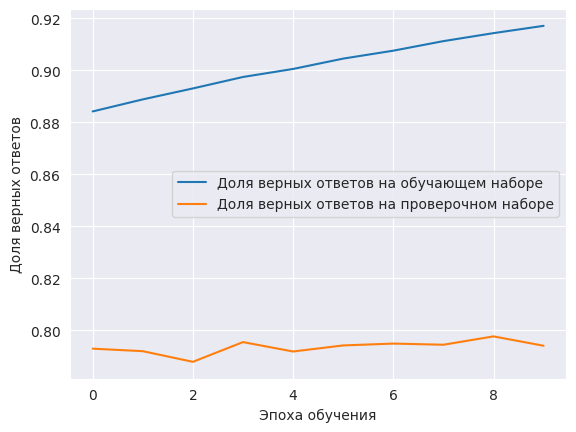

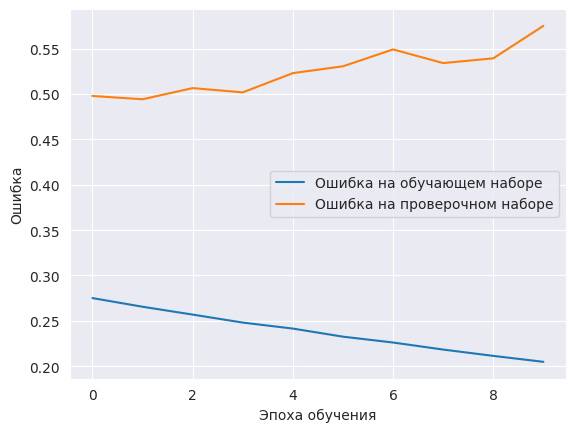

In [19]:
import time
start_time = time.time() # счетчик времени
history = model12_cl.fit(x,                            # Обучающая выборка
                        y,                               # Метки классов обучающей выборки
                        epochs=10,                             # Количество эпох
                        batch_size=1024,                         # Размер подвыборки для одного шага по данным на эпохе
                        validation_data=(x_val, y_val))   # Проверочная выборка и метки классов проверочной выборки

end_time = time.time() # счетчик времени
print("Время обучения: ", end_time - start_time) # вывод времени обучения
total_time = end_time - start_time # calculate the total time

print("Total time taken:", total_time, "seconds") # print the total time taken to train the model
print(max(history.history['accuracy'])) # print the highest accuracy achieved by the model

plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

plt.plot(history.history['loss'],
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

In [21]:
model12_cl.save('/content/gdrive/MyDrive/Colab Notebooks/Скоринг/model_last1.keras')

In [20]:
loss, acc = model12_cl.evaluate(x_test, y_test, verbose=0) #classification


In [22]:
acc

0.8125565052032471

10548/10548 [==============================] - 34s 3ms/step
[[73600  9438   132     1]
 [ 8736 77198  2916     1]
 [ 2822 10267 51830 19060]
 [    1     2  9892 71635]]


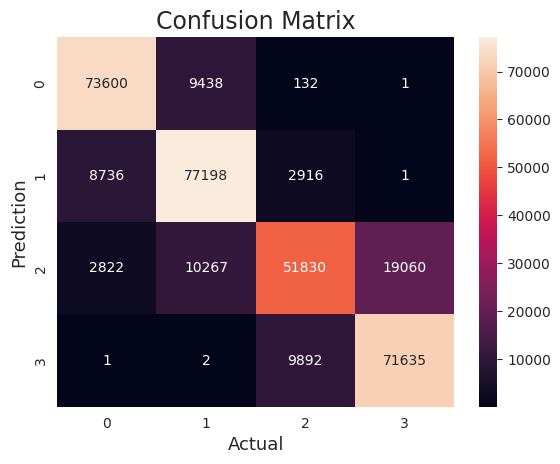

Accuracy   : 0.8125564762940293


In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# compute the confusion matrix
y_pred=model12_cl.predict(x_test)
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)
print(cm)

#Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
            fmt='g')
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()


# Finding precision and recall
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy   :", accuracy)

In [ ]:
#проверка работы сохраненной модели
model = load_model('/content/gdrive/MyDrive/Colab Notebooks/Скоринг/model_all_1.keras')

In [ ]:
loss, acc = model.evaluate(x_test, y_test, verbose=0) #classification

In [ ]:
acc

0.8266472220420837

In [ ]:
model.summary()# вывод лучшей архитектуры

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                2240      
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 4)                 132       
                                                                 
Total params: 4,708
Trainable params: 4,580
Non-trainable params: 128
_________________________________________________________________


#Модель1 Дмитрий

In [7]:

number_of_cols = x.shape[1]

model12_cl = Sequential() # Последовательная модель нейронной сети

model12_cl.add(Dense(544, input_dim=number_of_cols, activation='sigmoid'))
#model12_cl.add(BatchNormalization())
model12_cl.add(Dropout(0.2))
model12_cl.add(Dense(544, activation='sigmoid'))
model12_cl.add(Dropout(0.2))
#model12_cl.add(Dense(32, activation='sigmoid'))
model12_cl.add(Dense(4, activation='softmax'))

model12_cl.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 544)               20672     
                                                                 
 dropout (Dropout)           (None, 544)               0         
                                                                 
 dense_1 (Dense)             (None, 544)               296480    
                                                                 
 dropout_1 (Dropout)         (None, 544)               0         
                                                                 
 dense_2 (Dense)             (None, 4)                 2180      
                                                                 
Total params: 319,332
Trainable params: 319,332
Non-trainable params: 0
_________________________________________________________________


In [19]:
model12_cl.compile(optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'],
              loss='CategoricalCrossentropy')

In [9]:
x.shape, y.shape, x_val.shape, y_val.shape,

((1461850, 37), (1461850, 4), (126872, 37), (263566, 4))

In [21]:
import time
start_time = time.time() # счетчик времени
history = model12_cl.fit(x,                            # Обучающая выборка
                        y,                               # Метки классов обучающей выборки
                        epochs=10,                             # Количество эпох
                        batch_size=1024,                         # Размер подвыборки для одного шага по данным на эпохе
                        validation_data=(x_val, y_val))   # Проверочная выборка и метки классов проверочной выборки

end_time = time.time() # счетчик времени
print("Время обучения: ", end_time - start_time) # вывод времени обучения
total_time = end_time - start_time # calculate the total time

print("Total time taken:", total_time, "seconds") # print the total time taken to train the model
print(max(history.history['accuracy'])) # print the highest accuracy achieved by the model

plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

plt.plot(history.history['loss'],
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

Epoch 1/10
1428/1428 [==============================] - 124s 86ms/step - loss: 0.2223 - accuracy: 0.9084 - val_loss: 0.4245 - val_accuracy: 0.8306
Epoch 2/10
1428/1428 [==============================] - 109s 76ms/step - loss: 0.2175 - accuracy: 0.9106 - val_loss: 0.4332 - val_accuracy: 0.8274
Epoch 3/10
1428/1428 [==============================] - 111s 77ms/step - loss: 0.2118 - accuracy: 0.9133 - val_loss: 0.4629 - val_accuracy: 0.8248
Epoch 4/10
1428/1428 [==============================] - 112s 78ms/step - loss: 0.2059 - accuracy: 0.9161 - val_loss: 0.4422 - val_accuracy: 0.8314
Epoch 5/10
1428/1428 [==============================] - 114s 80ms/step - loss: 0.2005 - accuracy: 0.9186 - val_loss: 0.4651 - val_accuracy: 0.8242
Epoch 6/10
1428/1428 [==============================] - 116s 81ms/step - loss: 0.1950 - accuracy: 0.9209 - val_loss: 0.4550 - val_accuracy: 0.8259
Epoch 7/10
1428/1428 [==============================] - 114s 80ms/step - loss: 0.1901 - accuracy: 0.9230 - val_loss: 0

KeyboardInterrupt: ignored

In [ ]:
model12_cl.save('/content/gdrive/MyDrive/Colab Notebooks/Скоринг/model_lastD.keras')

In [ ]:
loss, acc = model12_cl.evaluate(x_test, y_test, verbose=0) #classification


In [ ]:
acc

0.8125565052032471

10548/10548 [==============================] - 34s 3ms/step
[[73600  9438   132     1]
 [ 8736 77198  2916     1]
 [ 2822 10267 51830 19060]
 [    1     2  9892 71635]]


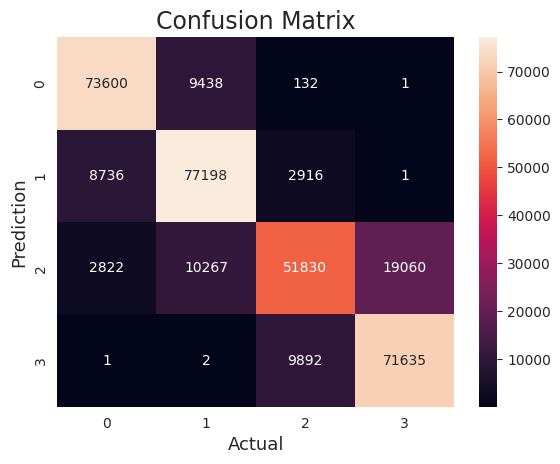

Accuracy   : 0.8125564762940293


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# compute the confusion matrix
y_pred=model12_cl.predict(x_test)
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)
print(cm)

#Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
            fmt='g')
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()


# Finding precision and recall
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy   :", accuracy)

In [ ]:
#проверка работы сохраненной модели
model = load_model('/content/gdrive/MyDrive/Colab Notebooks/Скоринг/model_all_1.keras')

In [ ]:
loss, acc = model.evaluate(x_test, y_test, verbose=0) #classification

In [ ]:
acc

0.8266472220420837

In [ ]:
model.summary()# вывод лучшей архитектуры

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                2240      
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 4)                 132       
                                                                 
Total params: 4,708
Trainable params: 4,580
Non-trainable params: 128
_________________________________________________________________


#Модель 2 Анна

In [24]:
model22_cl = load_model('/content/gdrive/MyDrive/Colab Notebooks/Скоринг/model2_last.keras')#Загрузка модели для дообучения

In [ ]:
number_of_cols = x.shape[1]

model22_cl = Sequential() # Последовательная модель нейронной сети

model22_cl.add(Dense(512, input_dim=number_of_cols, activation='elu'))
#model22_cl.add(BatchNormalization())
model22_cl.add(Dropout(0.2))
model22_cl.add(Dense(256, activation='elu'))
model22_cl.add(Dropout(0.2))
model22_cl.add(Dense(128, activation='elu'))
model22_cl.add(Dense(4, activation='softmax'))

model22_cl.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 512)               19456     
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dense_11 (Dense)            (None, 4)                 516       
                                                                 
Total params: 184,196
Trainable params: 184,196
Non-tr

In [ ]:
model22_cl.compile(optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'],
              loss='CategoricalCrossentropy')

In [ ]:
x.shape, y.shape

((1106976, 37), (1106976, 4))

Epoch 1/20
1082/1082 [==============================] - 66s 56ms/step - loss: 0.3185 - accuracy: 0.8713 - val_loss: 0.5223 - val_accuracy: 0.7978
Epoch 2/20
1082/1082 [==============================] - 59s 55ms/step - loss: 0.2727 - accuracy: 0.8849 - val_loss: 0.5941 - val_accuracy: 0.7834
Epoch 3/20
1082/1082 [==============================] - 61s 56ms/step - loss: 0.2662 - accuracy: 0.8883 - val_loss: 0.6061 - val_accuracy: 0.7807
Epoch 4/20
1082/1082 [==============================] - 65s 60ms/step - loss: 0.2528 - accuracy: 0.8943 - val_loss: 0.5651 - val_accuracy: 0.7875
Epoch 5/20
1082/1082 [==============================] - 61s 56ms/step - loss: 0.2472 - accuracy: 0.8976 - val_loss: 0.6823 - val_accuracy: 0.7854
Epoch 6/20
1082/1082 [==============================] - 62s 57ms/step - loss: 0.2357 - accuracy: 0.9029 - val_loss: 0.7622 - val_accuracy: 0.7256
Epoch 7/20
1082/1082 [==============================] - 59s 55ms/step - loss: 0.2271 - accuracy: 0.9072 - val_loss: 0.7449 -

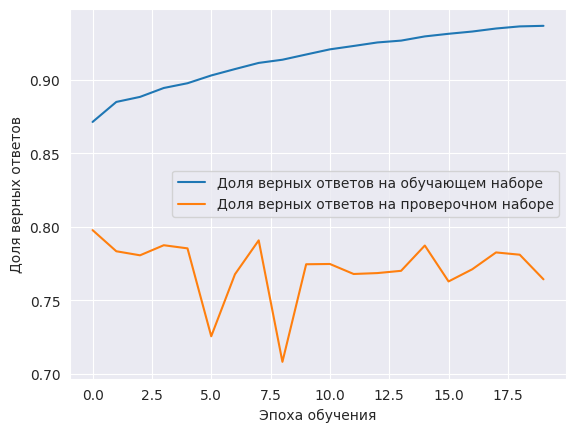

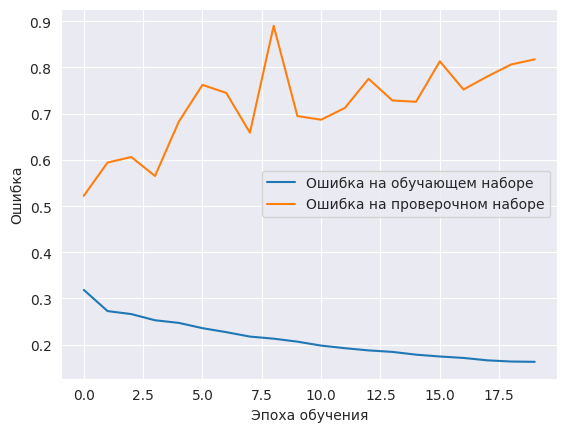

In [ ]:
import time
start_time = time.time() # счетчик времени
history = model22_cl.fit(x,                            # Обучающая выборка
                        y,                               # Метки классов обучающей выборки
                        epochs=20,                             # Количество эпох
                        batch_size=1024,                         # Размер подвыборки для одного шага по данным на эпохе
                        validation_data=(x_val, y_val))   # Проверочная выборка и метки классов проверочной выборки

end_time = time.time() # счетчик времени
print("Время обучения: ", end_time - start_time) # вывод времени обучения
total_time = end_time - start_time # calculate the total time

print("Total time taken:", total_time, "seconds") # print the total time taken to train the model
print(max(history.history['accuracy'])) # print the highest accuracy achieved by the model

plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

plt.plot(history.history['loss'],
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

In [ ]:
model22_cl.save('/content/gdrive/MyDrive/Colab Notebooks/Скоринг/model2_last.keras')

In [ ]:
loss, acc = model22_cl.evaluate(x_test, y_test, verbose=0) #classification



In [ ]:
acc

0.8269343972206116

In [25]:
# compute the confusion matrix
y_pred=model22_cl.predict(x_test)
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)
print(cm)

#Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
            fmt='g')
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()


# Finding precision and recall
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy   :", accuracy)

10548/10548 [==============================] - 37s 3ms/step


AxisError: ignored

#Модель 2 Дмитрий

In [ ]:
model22_cl = load_model('/content/gdrive/MyDrive/Colab Notebooks/Скоринг/model2_lastD.keras')#Загрузка модели для дообучения

In [47]:
number_of_cols = x.shape[1]

model22_cl = Sequential() # Последовательная модель нейронной сети

model22_cl.add(Dense(512, input_dim=number_of_cols, activation='sigmoid'))
model22_cl.add(BatchNormalization())
model22_cl.add(Dropout(0.2))
model22_cl.add(Dense(256, activation='sigmoid'))
model22_cl.add(Dropout(0.2))
model22_cl.add(Dense(128, activation='sigmoid'))
model22_cl.add(Dense(4, activation='softmax'))

model22_cl.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 512)               19456     
                                                                 
 batch_normalization_3 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_12 (Dropout)        (None, 512)               0         
                                                                 
 dense_24 (Dense)            (None, 256)               131328    
                                                                 
 dropout_13 (Dropout)        (None, 256)               0         
                                                                 
 dense_25 (Dense)            (None, 128)               32896     
                                                      

In [48]:
model22_cl.compile(optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'],
              loss='CategoricalCrossentropy')

In [25]:
x.shape, y.shape

((1461850, 37), (1461850, 4))

In [ ]:
import time
start_time = time.time() # счетчик времени
history = model22_cl.fit(x,                            # Обучающая выборка
                        y,                               # Метки классов обучающей выборки
                        epochs=10,                             # Количество эпох
                        batch_size=1024,                         # Размер подвыборки для одного шага по данным на эпохе
                        validation_data=(x_val, y_val))   # Проверочная выборка и метки классов проверочной выборки

end_time = time.time() # счетчик времени
print("Время обучения: ", end_time - start_time) # вывод времени обучения
total_time = end_time - start_time # calculate the total time

print("Total time taken:", total_time, "seconds") # print the total time taken to train the model
print(max(history.history['accuracy'])) # print the highest accuracy achieved by the model

plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

plt.plot(history.history['loss'],
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

Epoch 1/10
1428/1428 [==============================] - 98s 64ms/step - loss: 0.6784 - accuracy: 0.7072 - val_loss: 0.6551 - val_accuracy: 0.6746
Epoch 2/10
1428/1428 [==============================] - 87s 61ms/step - loss: 0.5040 - accuracy: 0.7793 - val_loss: 0.5256 - val_accuracy: 0.7765
Epoch 3/10
1428/1428 [==============================] - 87s 61ms/step - loss: 0.4525 - accuracy: 0.8010 - val_loss: 0.4235 - val_accuracy: 0.8156
Epoch 4/10
 627/1428 [============>.................] - ETA: 54s - loss: 0.4302 - accuracy: 0.8108

In [39]:
model22_cl.save('/content/gdrive/MyDrive/Colab Notebooks/Скоринг/model2_lastD.keras')

In [40]:
loss, acc = model22_cl.evaluate(x_test, y_test, verbose=0) #classification



In [41]:
acc

0.8367336392402649

In [ ]:
# compute the confusion matrix
y_pred=model22_cl.predict(x_test)
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)
print(cm)

#Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
            fmt='g')
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()


# Finding precision and recall
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy   :", accuracy)

10548/10548 [==============================] - 37s 3ms/step


AxisError: ignored

#База без id_nbki и dt_nbki

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87315 entries, 0 to 87314
Data columns (total 35 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   region_name                          87315 non-null  int8   
 1   city_name                            87315 non-null  int16  
 2   population                           87315 non-null  float64
 3   date of birth                        87315 non-null  int16  
 4   gender                               87315 non-null  int8   
 5   education                            87315 non-null  int8   
 6   position                             87315 non-null  int8   
 7   dt_nbki                              87315 non-null  int16  
 8   id_nbki                              87315 non-null  int16  
 9   issued                               87315 non-null  int16  
 10  amount                               87315 non-null  float64
 11  type_credit                 

In [ ]:
X1 = X.drop(columns = 'id_nbki')

In [ ]:
X1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87315 entries, 0 to 87314
Data columns (total 34 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   region_name                          87315 non-null  int8   
 1   city_name                            87315 non-null  int16  
 2   population                           87315 non-null  float64
 3   date of birth                        87315 non-null  int16  
 4   gender                               87315 non-null  int8   
 5   education                            87315 non-null  int8   
 6   position                             87315 non-null  int8   
 7   dt_nbki                              87315 non-null  int16  
 8   issued                               87315 non-null  int16  
 9   amount                               87315 non-null  float64
 10  type_credit                          87315 non-null  int8   
 11  status_credit               

Feature: date of birth Score: 1.3041760816519101
Feature: city_name Score: 0.5515053247673833
Feature: population Score: 0.5497316655783617
Feature: dt_nbki Score: 0.39611029323694424
Feature: type_debt Score: 0.2587135055855416
Feature: amount_principal_debt_repaid Score: 0.1506295910473261
Feature: last_payment Score: 0.1400519254130046
Feature: region_name Score: 0.1307855384112795
Feature: position Score: 0.1306951081545975
Feature: updated Score: 0.11770391928319413
Feature: date_credit_state Score: 0.1111140290130237
Feature: psk Score: 0.11031338544904212
Feature: balance Score: 0.10759546458925406
Feature: period Score: 0.09876526783980921
Feature: issued Score: 0.09866594350657643
Feature: education Score: 0.07398000549211847
Feature: amount Score: 0.06300619270423091
Feature: actual_payments_24_Months Score: 0.05740607727892222
Feature: current_indebtedness Score: 0.05638115714800307
Feature: maximum_amount_overdue_indebtedness Score: 0.054724168762001923
Feature: next_paymen

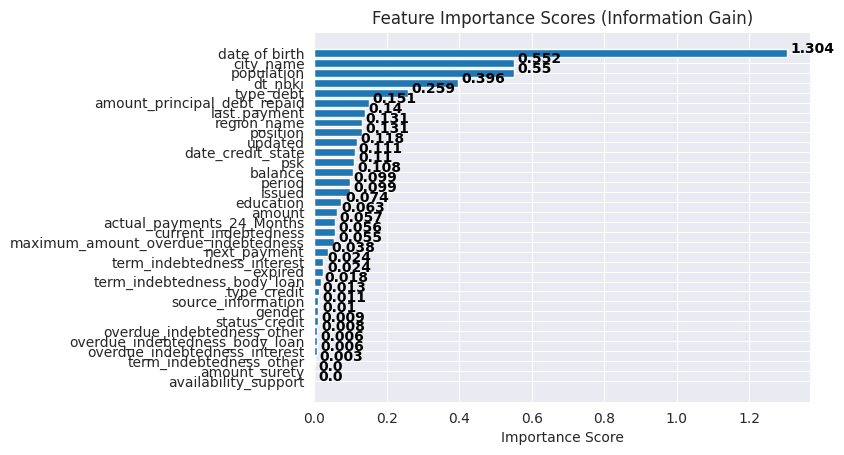

In [ ]:
# Apply Information Gain
ig = mutual_info_regression(X1, y)

# Create a dictionary of feature importance scores
feature_scores = {}
for i in range(len(X1.columns.values)):
    feature_scores[X1.columns.values[i]] = ig[i]
# Sort the features by importance score in descending order
sorted_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)

# Print the feature importance scores and the sorted features
for feature, score in sorted_features:
    print("Feature:", feature, "Score:", score)
# Plot a horizontal bar chart of the feature importance scores
fig, ax = plt.subplots()
y_pos = np.arange(len(sorted_features))
ax.barh(y_pos, [score for feature, score in sorted_features], align="center")
ax.set_yticks(y_pos)
ax.set_yticklabels([feature for feature, score in sorted_features])
ax.invert_yaxis()  # Labels read top-to-bottom
ax.set_xlabel("Importance Score")
ax.set_title("Feature Importance Scores (Information Gain)")

# Add importance scores as labels on the horizontal bar chart
for i, v in enumerate([score for feature, score in sorted_features]):
    ax.text(v + 0.01, i, str(round(v, 3)), color="black", fontweight="bold")
plt.show()

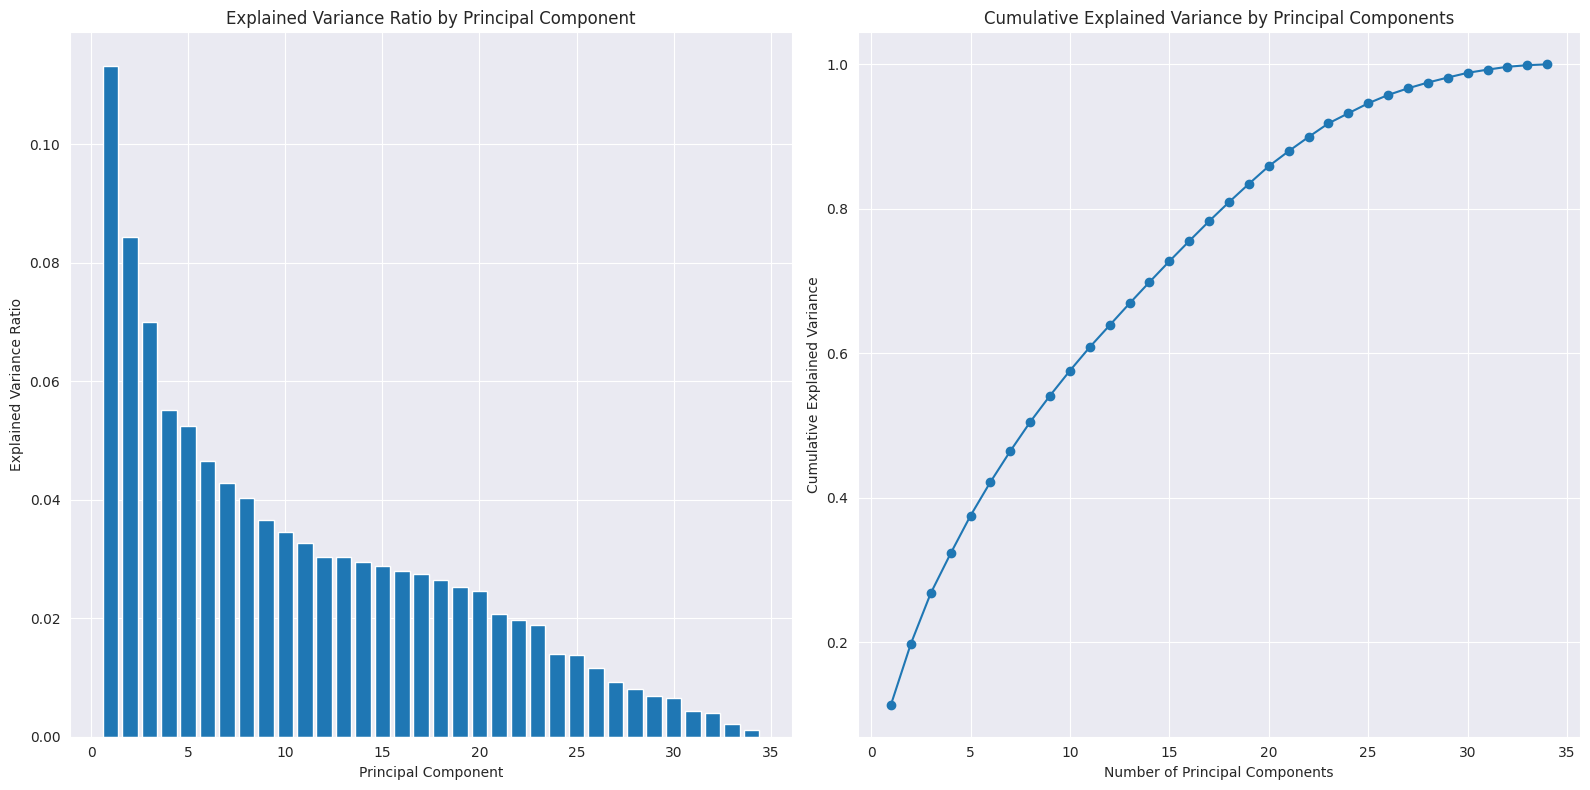

In [ ]:
# Standardize the features

X1_scaled = scaler.fit_transform(X1)

# Perform PCA
pca = PCA()
X1_pca = pca.fit_transform(X1_scaled)

# Calculate the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Create a 2x1 grid of subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# Plot the explained variance ratio in the first subplot
ax1.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
ax1.set_xlabel("Principal Component")
ax1.set_ylabel("Explained Variance Ratio")
ax1.set_title("Explained Variance Ratio by Principal Component")

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot the cumulative explained variance in the second subplot
ax2.plot(
    range(1, len(cumulative_explained_variance) + 1),
    cumulative_explained_variance,
    marker="o",
)
ax2.set_xlabel("Number of Principal Components")
ax2.set_ylabel("Cumulative Explained Variance")
ax2.set_title("Cumulative Explained Variance by Principal Components")

# Display the figure
plt.tight_layout()
plt.show()

In [ ]:
#Как видно из графиков, основными являются первые 16 признаков, они охватывают более 80% общей дисперсии

In [ ]:
X1 = X.drop(columns = 'expired')
X1 = X.drop(columns = 'term_indebtedness_interest')
X1 = X.drop(columns = 'term_indebtedness_body_loan')
X1 = X.drop(columns = 'type_credit')
X1 = X.drop(columns = 'gender')
X1 = X.drop(columns = 'maximum_amount_overdue_indebtedness')
#X1 = X.drop(columns = 'availability_support')
X1 = X.drop(columns = 'overdue_indebtedness_body_loan')
X1 = X.drop(columns = 'overdue_indebtedness_interest')
X1 = X.drop(columns = 'overdue_indebtedness_other')
X1 = X.drop(columns = 'term_indebtedness_other')
X1 = X.drop(columns = 'amount_surety')

In [ ]:
X1 = X.drop(columns = 'overdue_indebtedness_body_loan')
X1 = X.drop(columns = 'overdue_indebtedness_interest')
X1 = X.drop(columns = 'overdue_indebtedness_other')
X1 = X.drop(columns = 'term_indebtedness_other')
X1 = X.drop(columns = 'amount_surety')

In [ ]:
X1.shape


(87315, 34)

In [ ]:
y = to_categorical(y, num_classes = 4)

print('Размер y:',y.shape)

Размер y: (87315, 4)


In [ ]:
# разбиваем на train и test
x1_train, x1_test, y1_train, y1_test = train_test_split(X1, y, shuffle=True, test_size=0.2, random_state=42, stratify=y)
print('Размер x1_train:',x1_train.shape)
print('Размер y1_train:',y1_train.shape)

Размер x1_train: (69852, 34)
Размер y1_train: (69852, 4)


In [ ]:
number_of_cols = x1_train.shape[1]

model123 = Sequential() # Последовательная модель нейронной сети

model123.add(Dense(512, input_dim=number_of_cols, activation='relu'))

model123.add(Dense(256, activation='relu'))
#model12.add(Dense(32, activation='relu'))
model123.add(Dense(4, activation='softmax'))

model123.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 512)               17920     
                                                                 
 dense_16 (Dense)            (None, 256)               131328    
                                                                 
 dense_17 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 150276 (587.02 KB)
Trainable params: 150276 (587.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model123.compile(optimizer=Adam(learning_rate=0.005),
              metrics=['accuracy'],
              loss='CategoricalCrossentropy')

Epoch 1/100
69/69 [==============================] - 3s 31ms/step - loss: 7294.4937 - accuracy: 0.2873 - val_loss: 1.6347 - val_accuracy: 0.2806
Epoch 2/100
69/69 [==============================] - 2s 25ms/step - loss: 1.5242 - accuracy: 0.2739 - val_loss: 1.4173 - val_accuracy: 0.2670
Epoch 3/100
69/69 [==============================] - 2s 26ms/step - loss: 1.5285 - accuracy: 0.2719 - val_loss: 1.4131 - val_accuracy: 0.2735
Epoch 4/100
69/69 [==============================] - 2s 29ms/step - loss: 1.4950 - accuracy: 0.2749 - val_loss: 1.4650 - val_accuracy: 0.2742
Epoch 5/100
69/69 [==============================] - 2s 26ms/step - loss: 1.4059 - accuracy: 0.2733 - val_loss: 1.3813 - val_accuracy: 0.2734
Epoch 6/100
69/69 [==============================] - 3s 41ms/step - loss: 1.3712 - accuracy: 0.2795 - val_loss: 1.3768 - val_accuracy: 0.2782
Epoch 7/100
69/69 [==============================] - 3s 44ms/step - loss: 1.3718 - accuracy: 0.2734 - val_loss: 1.3887 - val_accuracy: 0.2734
Epo

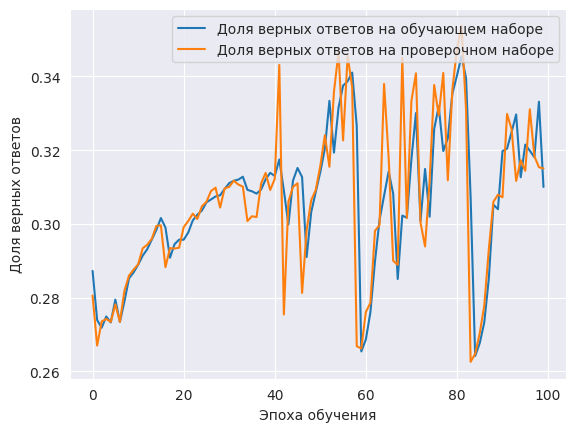

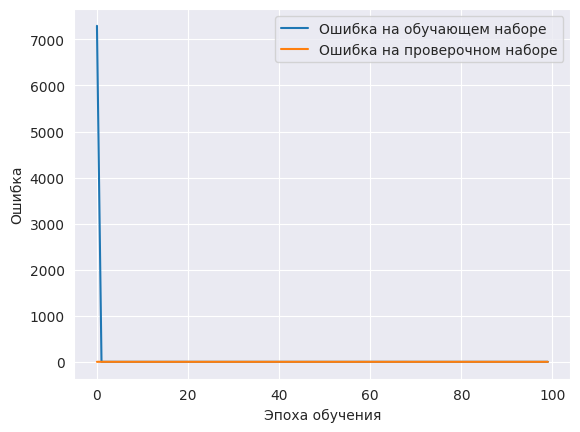

In [ ]:
import time
start_time = time.time() # счетчик времени
history_1 = model123.fit(x1_train,                            # Обучающая выборка
                        y1_train,                               # Метки классов обучающей выборки
                        epochs=100,                             # Количество эпох
                        batch_size=1024,                         # Размер подвыборки для одного шага по данным на эпохе
                        validation_data=(x1_test, y1_test))   # Проверочная выборка и метки классов проверочной выборки

end_time = time.time() # счетчик времени
print("Время обучения: ", end_time - start_time) # вывод времени обучения
total_time = end_time - start_time # calculate the total time

print("Total time taken:", total_time, "seconds") # print the total time taken to train the model
print(max(history_1.history['accuracy'])) # print the highest accuracy achieved by the model

plt.plot(history_1.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_1.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

plt.plot(history_1.history['loss'],
         label='Ошибка на обучающем наборе')
plt.plot(history_1.history['val_loss'],
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

In [ ]:
model123.save('/content/gdrive/MyDrive/Colab Notebooks/Скоринг/model123.keras')

In [ ]:
loss, acc = model123(x_test, y_test, verbose=0) #classification

y_predictions = model123(x_test)# оценка производительности модели

ValueError: ignored

#Загрузка тестовой базы

In [ ]:
db_test = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Скоринг/Test1.csv')

<ipython-input-103-a06967b04cc2>:1: DtypeWarning: Columns (15,31,33,37,40) have mixed types. Specify dtype option on import or set low_memory=False.
  db_test = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Скоринг/Test1.csv')


In [ ]:
db_test.shape

(139221, 42)

In [ ]:
db_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25552 entries, 0 to 25551
Data columns (total 42 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   region_name                          25442 non-null  object 
 1   city_name                            25442 non-null  object 
 2   population                           25442 non-null  float64
 3   date of birth                        25552 non-null  object 
 4   gender                               25552 non-null  object 
 5   education                            20789 non-null  object 
 6   position                             24903 non-null  object 
 7   dt_nbki                              25552 non-null  object 
 8   id_nbki                              25552 non-null  object 
 9   issued                               25526 non-null  object 
 10  amount                               25526 non-null  float64
 11  currency                    

In [ ]:
db_test['Client_class'].unique()

array([0, 1, 2, 3])

In [ ]:
db_test['Client_class'].isnull().mean()*100

0.0

In [ ]:
db_test = db_test.drop(columns=['period_interest', 'days_overdue', 'volume_commitment', 'surety_period',
       'beginning_days_delinquency_counting', 'type_debt', 'availability_support'])

In [ ]:
obj_db = db_test.select_dtypes(include=['object']).copy()
obj_db.dtypes

region_name           object
city_name             object
date of birth         object
gender                object
education             object
position              object
dt_nbki               object
id_nbki               object
issued                object
currency              object
type_credit           object
status_credit         object
period                object
last_payment          object
updated               object
source_information    object
date_credit_state     object
dtype: object

In [ ]:
db_test["region_name"] = db_test["region_name"].astype('category')
db_test["region_name"] = db_test["region_name"].cat.codes

In [ ]:
db_test["city_name"] = db_test["city_name"].astype('category')
db_test["city_name"] = db_test["city_name"].cat.codes

In [ ]:
db_test["date of birth"] = db_test["date of birth"].astype('category')
db_test["date of birth"] = db_test["date of birth"].cat.codes

In [ ]:
db_test["gender"] = db_test["gender"].astype('category')
db_test["gender"] = db_test["gender"].cat.codes

In [ ]:
db_test["education"] = db_test["education"].astype('category')
db_test["education"] = db_test["education"].cat.codes

In [ ]:
db_test["position"] = db_test["position"].astype('category')
db_test["position"] = db_test["position"].cat.codes

In [ ]:
db_test["dt_nbki"] = db_test["dt_nbki"].astype('category')
db_test["dt_nbki"] = db_test["dt_nbki"].cat.codes

In [ ]:
db_test["id_nbki"] = db_test["id_nbki"].astype('category')
db_test["id_nbki"] = db_test["id_nbki"].cat.codes

In [ ]:
db_test["issued"] = db_test["issued"].astype('category')
db_test["issued"] = db_test["issued"].cat.codes

In [ ]:
db_test["type_credit"] = db_test["type_credit"].astype('category')
db_test["type_credit"] = db_test["type_credit"].cat.codes

In [ ]:
db_test["status_credit"] = db_test["status_credit"].astype('category')
db_test["status_credit"] = db_test["status_credit"].cat.codes

In [ ]:
db_test["period"] = db_test["period"].astype('category')
db_test["period"] = db_test["period"].cat.codes

In [ ]:
db_test["last_payment"] = db_test["last_payment"].astype('category')
db_test["last_payment"] = db_test["last_payment"].cat.codes

In [ ]:
db_test["updated"] = db_test["updated"].astype('category')
db_test["updated"] = db_test["updated"].cat.codes

In [ ]:
db_test["source_information"] = db_test["source_information"].astype('category')
db_test["source_information"] = db_test["source_information"].cat.codes

In [ ]:
db_test["date_credit_state"] = db_test["date_credit_state"].astype('category')
db_test["date_credit_state"] = db_test["date_credit_state"].cat.codes

In [ ]:
db_test = db_test.loc[db_test['currency'] == 'RUB']

In [ ]:
db_test['currency'].unique()

array(['RUB'], dtype=object)

In [ ]:
db_test = db_test.drop(columns='currency')#удаление столбца валюта

In [ ]:
from datetime import datetime
today = datetime.today()
db_test['date of birth'] = pd.to_datetime(db_test['date of birth'])
db_test['age'] = db_test['date of birth'].apply(
               lambda x: today.year - x.year -
               ((today.month, today.day) < (x.month, x.day))
               )

In [ ]:
db_test = db_test.drop(columns='date of birth')

In [ ]:
# Подсчет количества уникальных значений
education_counts = db_test['education'].value_counts()

# Вычисление процентного соотношения
education_percentages = round((education_counts / education_counts.sum()) * 100, 3)

# Вывод результатов
print(education_percentages)


Среднее              37.289
СреднеТехническое    35.928
Высшее               21.319
НеполноеВысшее        2.987
НеполноеСреднее       2.477
Name: education, dtype: float64


In [ ]:
# Создаем словарь с соответствиями значений для замены
replace_dict = {
    'СреднеТехническое': 'Среднее',
    'НесколькоВысших': 'Высшее',
    'НеполноеВысшее': 'Неполное',
    'НеполноеСреднее': 'Неполное',
    'УченаяСтепень': 'Высшее'
}

# Заменяем значения в столбце 'education' с использованием словаря замены
db_test['education'] = db_test['education'].replace(replace_dict)

In [ ]:
# Пустые значения
db_test['education'] = db_test['education'].fillna('Неполное')
db_test['education'].isnull().mean()*100

0.0

In [ ]:
from sklearn import preprocessing  # кодировка переменной



my_label = preprocessing.LabelEncoder()

In [ ]:
db_test['education']= my_label.fit_transform(db_test['education'])
print(db_test['education'].unique())
print("Data Frame after Label Encoding:\n")
db_test.head(5)

[1 2 0]
Data Frame after Label Encoding:



,region_name,city_name,population,gender,education,position,dt_nbki,id_nbki,issued,amount,...,overdue_indebtedness_interest,overdue_indebtedness_other,actual_payments_24_Months,amount_surety,source_information,maximum_amount_overdue_indebtedness,date_credit_state,amount_principal_debt_repaid,Client_class,age
0,Свердловская область,г.Каменск-Уральский,170922.0,Мужской,1,руководитель,2023-02-21,3cfbdefc-b1d3-11ed-b80d-3cfdfed12971,2013-11-07,290057.0,...,0.0,0.0,0.0,0.0,Банк,0.0,2017-12-19,0.00,0,32
1,Свердловская область,г.Каменск-Уральский,170922.0,Мужской,1,руководитель,2023-02-21,3cfbdefc-b1d3-11ed-b80d-3cfdfed12971,2013-09-23,0.0,...,0.0,0.0,0.0,0.0,Банк,0.0,2019-10-09,19877.53,0,32
2,Свердловская область,г.Каменск-Уральский,170922.0,Мужской,1,руководитель,2023-02-21,3cfbdefc-b1d3-11ed-b80d-3cfdfed12971,2015-12-09,30000.0,...,0.0,0.0,0.0,0.0,МФО,0.0,2016-09-07,30000.00,0,32
3,Свердловская область,г.Каменск-Уральский,170922.0,Мужской,1,руководитель,2023-02-21,3cfbdefc-b1d3-11ed-b80d-3cfdfed12971,2016-08-08,26000.0,...,0.0,0.0,0.0,0.0,МФО,0.0,2017-02-06,26000.00,0,32
4,Свердловская область,г.Каменск-Уральский,170922.0,Мужской,1,руководитель,2023-02-21,3cfbdefc-b1d3-11ed-b80d-3cfdfed12971,2016-12-28,40000.0,...,0.0,0.0,0.0,0.0,МФО,0.0,2019-02-28,28621.52,0,32


In [ ]:
# Подсчет количества уникальных значений
position_counts = db_test['position'].value_counts()

# Вычисление процентного соотношения
position_percentages = round((position_counts / position_counts.sum()) * 100, 3)

# Вывод результатов
position_percentages

пенсионер                                 28.242
рабочий                                   14.922
сотрудник малого бизнеса                  12.135
специалист                                 8.356
работник промышленных предприятий          6.714
сотрудники крупного бизнеса                6.244
работник бюджетной сферы                   5.638
муниципальный служащий                     3.690
прочее                                     2.686
индивидуальный предприниматель (ип)        2.080
госслужащий                                2.040
работник с/х                               1.763
самозанятый                                1.422
военнослужащий                             1.285
работник социальной сферы                  1.000
технический специалист                     0.811
руководитель                               0.622
сотрудник градообразующего предприятия     0.349
Name: position, dtype: float64

In [ ]:
replace_dict1 = {
    'государственные служащие высоких чинов': 'госслужащий',
    'судебная власть, права человека': 'госслужащий',
    'технический специалист': 'специалист',
    'работник социальной сферы': 'прочее',
    'работник с/х': 'прочее',
    'сотрудник градообразующего предприятия': 'рабочий',
    'муниципальный служащий': 'работник бюджетной сферы',
    'госслужащий': 'работник бюджетной сферы',
    'военнослужащий': 'прочее',
    'руководитель': 'специалист',
    'самозанятый': 'прочее',
    'муниципальный служащий': 'работник бюджетной сферы',
    'разнорабочий': 'рабочий',
    'сварщик': 'рабочий',
    'водитель': 'рабочий',
}

In [ ]:
# Заменяем значения в столбце 'position' с использованием словаря замены
db_test['position'] = db_test['position'].replace(replace_dict1)

In [ ]:
# Пустые значения
db_test['position'] = db_test['position'].fillna('прочее')
db_test['position'].isnull().mean()*100

0.0

In [ ]:
db_test['position']= my_label.fit_transform(db_test['position']) # кодировка переменной
print(db_test['position'].unique())
print("Data Frame after Label Encoding:\n")


[8 2 1 7 4 3 6 0 5]
Data Frame after Label Encoding:



In [ ]:
db_test['gender']= my_label.fit_transform(db_test['gender'])  # кодировка переменной
print(db_test['gender'].unique())
print("Data Frame after Label Encoding:\n")


[1 0]
Data Frame after Label Encoding:



In [ ]:
db_test = db_test.drop(columns='currency')#удаление столбца валюта

In [ ]:
replace_dict2 = {
    'ИпотекаПервичныйРынок': 'ДругойТипКредита',
    'ИпотекаВторичныйРынок': 'ДругойТипКредита',
    'НаОбучение': 'ДругойТипКредита',
    'НаСтроительство': 'ДругойТипКредита',
    'БанковскаяГарантия': 'ДругойТипКредита',
    'PDLЗайм': 'ДругойТипКредита',
    'ДоговорПоручительства': 'ДругойТипКредита',
    'НаРазвитиеБизнеса': 'ДругойТипКредита',
    'НаПополнениеОборотныхСредств': 'ДругойТипКредита',
    'ДебетоваяКартаСОвердрафтом': 'ДругойТипКредита',
    'КредитНаличнымиНецелевой': 'ДругойТипКредита',
    'КредитНаАвтомобиль': 'ДругойТипКредита',
    'Овердрафт': 'ДругойТипКредита',
    'НаПокупкуОборудования': 'ДругойТипКредита',
    'Ипотека': 'ДругойТипКредита',
    'Потребительский': 'ДругойТипКредита',
    'КредитнаяКарта': 'ДругойТипКредита'
}


In [ ]:
# Заменяем значения в столбце 'type_credit' с использованием словаря замены
db_test['type_credit'] = db_test['type_credit'].replace(replace_dict2)

In [ ]:
# Пустые значения
db_test['type_credit'] = db_test['type_credit'].fillna('ДругойТипКредита')
db_test['type_credit'].isnull().mean()*100

0.0

In [ ]:
db_test['type_credit']= my_label.fit_transform(db_test['type_credit'])  # кодировка переменной
print(db_test['type_credit'].unique())
print("Data Frame after Label Encoding:\n")

[0 1]
Data Frame after Label Encoding:



In [ ]:
db_test = db_test.drop(columns='region_name')#удаление столбца region_name

In [ ]:
db_test = db_test.drop(columns='city_name')

In [ ]:
db_test = db_test.dropna (subset=['population'])#удаление строк с пустым population

In [ ]:
db_test['status_credit'].value_counts()

СчетЗакрыт                                 19216
Активный                                    3849
Просрочен                                   1483
ПереданНаОбслуживаниеВДругуюОрганизацию      691
ПередачаДанныхПрекращена                      88
ПроблемыСВозвратом                            56
Рефинансирован                                23
Банкротство                                    2
СписанСБаланса                                 2
Спор                                           1
ОплаченЗаСчетОбеспечения                       1
Name: status_credit, dtype: int64

In [ ]:
# Создаем словарь с соответствиями значений для замены
db_test.loc[db_test["status_credit"] == "СчетЗакрыт", "status_credit"] = 0
db_test.loc[db_test["status_credit"] == "Активный", "status_credit"] = 2
db_test.loc[db_test["status_credit"] == "Просрочен", "status_credit"] = 1
db_test.loc[db_test["status_credit"] == "ПереданНаОбслуживаниеВДругуюОрганизацию", "status_credit"] = 1
db_test.loc[db_test["status_credit"] == "ПередачаДанныхПрекращена", "status_credit"] = 1
db_test.loc[db_test["status_credit"] == "ПроблемыСВозвратом", "status_credit"] = 1
db_test.loc[db_test["status_credit"] == "Рефинансирован", "status_credit"] = 1
db_test.loc[db_test["status_credit"] == "Банкротство", "status_credit"] = 1
db_test.loc[db_test["status_credit"] == "СписанСБаланса", "status_credit"] = 1
db_test.loc[db_test["status_credit"] == "ПринудительноеИсполнение", "status_credit"] = 1
db_test.loc[db_test["status_credit"] == "Спор", "status_credit"] = 1
db_test.loc[db_test["status_credit"] == "ОплаченЗаСчетОбеспечения", "status_credit"] = 1
db_test.loc[db_test["status_credit"] == "Расторгнут", "status_credit"] = 1

In [ ]:
db_test = db_test.dropna (subset=['status_credit'])#удаление строк с пустым status_credit

In [ ]:
db_test['status_credit']= my_label.fit_transform(db_test['status_credit'])  # кодировка переменной
print(db_test['status_credit'].unique())
print("Data Frame after Label Encoding:\n")

[0 1 2]
Data Frame after Label Encoding:



In [ ]:
#db_test = db_test.drop(columns='source_information')#удаление столбца source_information

In [ ]:
db_test['source_information'] = db_test['source_information'].replace(replace_dict3)

In [ ]:
db_test['source_information']= my_label.fit_transform(db_test['source_information'])  # кодировка переменной
print(db_test['source_information'].unique())
print("Data Frame after Label Encoding:\n")
db.head(5)

[2 0 1]
Data Frame after Label Encoding:



,population,gender,education,position,dt_nbki,id_nbki,issued,amount,type_credit,status_credit,...,overdue_indebtedness_interest,overdue_indebtedness_other,actual_payments_24_Months,amount_surety,source_information,maximum_amount_overdue_indebtedness,date_credit_state,amount_principal_debt_repaid,Client_class,age
0,618150.0,1,0,6,2022,1575,2022,1720.0,1,0,...,0.0,0.0,0.0,0.0,2,0.0,2022,1720.00,1,31
1,618150.0,1,0,6,2022,1575,2022,2920.0,1,2,...,0.0,0.0,0.0,0.0,2,0.0,2022,265.45,1,31
2,22408.0,0,2,6,2022,483,2022,3000.0,1,0,...,0.0,0.0,0.0,0.0,2,0.0,2022,3000.00,1,56
3,22408.0,0,2,6,2022,483,2022,1960.0,1,2,...,0.0,0.0,0.0,0.0,2,0.0,2022,2040.00,1,56
4,22408.0,0,2,6,2022,483,2022,4000.0,1,2,...,0.0,0.0,0.0,0.0,2,0.0,2022,2012.00,1,56


In [ ]:
db_test['issued'] = pd.to_datetime(db_test['issued'])

In [ ]:
db_test['issued'] = db_test['issued'].dt.year

In [ ]:
index = db_test[db_test['issued'] < 2021.00].index#оставляем только кредиты выданные ранее 2021 года
db_test.drop(index, inplace=True)

In [ ]:
db_test['issued'].value_counts()

2022    7308
2021    5001
2023     362
Name: issued, dtype: int64

In [ ]:
CLMN = "period"
value_for_NA = pd.to_datetime("1900-01-01 00:00:00")
# преобразование в пандосовский тип дат
db_test[CLMN] = pd.to_datetime(db_test[CLMN], errors='coerce').fillna(value_for_NA)
print(type(db_test["period"]))
# Преобразование столбца 'period' в тип данных datetime, если он еще не является datetime
db_test['period'] = pd.to_datetime(db_test['period'])

<class 'pandas.core.series.Series'>


In [ ]:
db_test['period'] = db_test['period'].dt.year
index = db_test[db_test['period'] < 2021.00].index#оставляем только кредиты со сроком погашения не ранее 2021 года (т.к. и выдачу ограничили 2021)
db_test.drop(index, inplace=True)

In [ ]:
# Преобразование столбца 'last_payment' в тип данных datetime, если он еще не является datetime
db_test['last_payment'] = pd.to_datetime(db_test['last_payment'])

db_test['last_payment'] = db_test['last_payment'].dt.year

db_test.loc[db_test["last_payment"] == 1900, "last_payment"] = 2021 # фильтрация по дате открытия и по дате закрытия ранее была. Заменим данное значение ранним годом из всех вариантов для того чтобы не терать данные

# Пустые значения
db_test['last_payment'] = db_test['last_payment'].fillna(2021.00)
db_test['last_payment'].isnull().mean()*100

0.0

In [ ]:
# Преобразование столбца 'dt_nbki' в тип данных datetime, если он еще не является datetime
db_test['dt_nbki'] = pd.to_datetime(db_test['dt_nbki'])

db_test['dt_nbki'] = db_test['dt_nbki'].dt.year


In [ ]:
db_test = db_test.drop(columns='updated')# удалила столбец, он почти полностью дублирует следующий и вряд ли несет смысловую нагрузку

In [ ]:
# Преобразование столбца 'date_credit_state' в тип данных datetime, если он еще не является datetime
db_test['date_credit_state'] = pd.to_datetime(db_test['date_credit_state'])

db_test['date_credit_state'] = db_test['date_credit_state'].dt.year

index = db_test[db_test['date_credit_state'] < 2011.00].index
db_test.drop(index, inplace=True)

# Пустые значения
db_test['date_credit_state'] = db_test['date_credit_state'].fillna(2021.00)
db_test['date_credit_state'].isnull().mean()*100

0.0

In [ ]:
db_test['id_nbki']= my_label.fit_transform(db_test['id_nbki'])  # кодировка переменной
print(db_test['id_nbki'].unique())
print("Data Frame after Label Encoding:\n")

[158 409  96  73 325  59 249 636  36 385 357 422  95 461 187  38 291 588
 318 583 109 453   4 367 529 493 340 650 608 647 424 133 307 447 326 194
 504 439 544 102   5 460 294 283 566  48  55 634 374 489 626 218  75 183
 344   0 519 182 508 324 624 614 405 101 288 448 470 269 360 117 108 399
 635 490 366 151  63 497 286 369 411 602 136 645 522 315 533 565 511   3
  22 505  87  89 603 308 390 523  85 421  44 611 393 481 154 548 321  20
   1 164 452 604 498 423 593 363  40 189 128  57  65  51 300 169  99 541
 132 467  26 105 623 577 338 230 615 225 486 115 384 122 237 266  58 364
  98 258 638 223 163  50  53 591 362 429 377 295  30 546 347 316  82 142
  69  23 279  12 346 343  49 520 554 162  72 586 531 552 302 567 365 172
 612  83 310 530 256 205 562 469 196 503  84 274 450 618 323 589 551 134
 165 118 573 175 610 161 156 372 171 464  37 484 561 557 537 499 571  76
 314 140 155 234 119 188 403 406 207 528 257 273 599 190 526 298 435 125
  86 381 500 198 243 248 416 637 598 438 176 568 53

In [ ]:
db_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25539 entries, 0 to 25551
Data columns (total 34 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   region_name                          25539 non-null  int8   
 1   city_name                            25539 non-null  int16  
 2   population                           25429 non-null  float64
 3   date of birth                        25539 non-null  int16  
 4   gender                               25539 non-null  int8   
 5   education                            25539 non-null  int8   
 6   position                             25539 non-null  int8   
 7   dt_nbki                              25539 non-null  int16  
 8   id_nbki                              25539 non-null  int16  
 9   issued                               25539 non-null  int16  
 10  amount                               25525 non-null  float64
 11  type_credit                 

#Предсказание на тестовой базе

In [ ]:
db_test = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Скоринг/db_test_cat_cl.csv')

In [ ]:
db_test = db# возвращаем переменной датафрейм тестовый после обработки на пропущенные значения и перевот в категории

In [ ]:
Xt = db_test.drop('Client_class', axis=1)
yt = np.array(db_test['Client_class'])

In [ ]:
db_test['Client_class'].unique()

array([0, 1, 2, 3])

In [ ]:
Xt.shape

(138994, 35)

In [ ]:
yt.shape

(138994,)

In [ ]:
yt = utils.to_categorical(yt)

In [ ]:
 # Нормализуем данные
scaler = StandardScaler(with_mean=False) # Нормализуем данные
scaler.fit(Xt)
xt = scaler.transform(Xt)

In [ ]:
xt

array([[2.39128619, 3.04847426, 0.26818047, ..., 1.84004257, 0.        ,
        1.58632411],
       [2.39128619, 3.04847426, 0.26818047, ..., 2.69926361, 0.304755  ,
        1.58632411],
       [2.39128619, 3.04847426, 0.26818047, ..., 1.28014581, 0.45994899,
        1.58632411],
       ...,
       [0.09760352, 2.26056092, 0.28601869, ..., 4.13040784, 0.        ,
        0.        ],
       [0.09760352, 2.26056092, 0.28601869, ..., 4.12639903, 0.        ,
        0.        ],
       [0.09760352, 2.26056092, 0.28601869, ..., 4.14377053, 0.        ,
        0.        ]])

In [ ]:
xt_train, xt_test, yt_train, yt_test = train_test_split(xt, yt, shuffle=True, test_size=0.2, random_state=42, stratify=yt)
print('Размер xt_train:',xt_train.shape)
print('Размер yt_train:',yt_train.shape)

Размер xt_train: (20328, 34)
Размер yt_train: (20328,)


In [ ]:

# Преобразование ответов в формат one_hot_encoding
yt_train = utils.to_categorical(yt_train)
yt_test = utils.to_categorical(yt_test)

print('Размер yt_train:',yt_train.shape)
print('Размер yt_test:',yt_test.shape)

# подготовка к обучению модели
scaler = StandardScaler()
scaler.fit(xt_test)

Размер yt_train: (20328, 4)
Размер yt_test: (5082, 4)


StandardScaler()

In [ ]:
model = load_model('/content/gdrive/MyDrive/Colab Notebooks/Скоринг/model.keras')

In [ ]:
loss, acc = model12_cl.evaluate(xt, yt) #classification

y_predictions = model12_cl.predict(xt)# оценка производительности модели

4344/4344 [==============================] - 12s 3ms/step


In [ ]:
acc

0.04008806124329567

In [ ]:
loss, acc = model22_cl.evaluate(xt, yt) #classification

y_predictions = model22_cl.predict(xt)# оценка производительности модели

4344/4344 [==============================] - 15s 3ms/step


In [ ]:
acc

0.12986890971660614

#Предсказание на тестовой базе без id_nbki

In [ ]:
Xt1 = Xt.drop(columns = 'id_nbki')

In [ ]:
Xt1 = Xt.drop(columns = 'expired')
Xt1 = Xt.drop(columns = 'term_indebtedness_interest')
Xt1 = Xt.drop(columns = 'term_indebtedness_body_loan')
Xt1 = Xt.drop(columns = 'type_credit')
Xt1 = Xt.drop(columns = 'gender')
Xt1 = Xt.drop(columns = 'maximum_amount_overdue_indebtedness')
#Xt1 = X.drop(columns = 'availability_support')
Xt1 = Xt.drop(columns = 'overdue_indebtedness_body_loan')
Xt1 = Xt.drop(columns = 'overdue_indebtedness_interest')
Xt1 = Xt.drop(columns = 'overdue_indebtedness_other')
Xt1 = Xt.drop(columns = 'term_indebtedness_other')
Xt1 = Xt.drop(columns = 'amount_surety')

In [ ]:
Xt1.shape

(25410, 33)

In [ ]:
 # Нормализуем данные
scaler = StandardScaler(with_mean=False) # Нормализуем данные
scaler.fit(Xt1)
xt1 = scaler.transform(Xt1)

In [ ]:
print('Размер Xt1:',Xt1.shape)
print('Размер yt:',yt.shape)

Размер Xt1: (25410, 33)
Размер yt: (25410, 4)


In [ ]:
# Преобразование ответов в формат one_hot_encoding
yt1 = utils.to_categorical(yt)

In [ ]:
# разбиваем на train и test
xt1_train, xt1_test, yt1_train, yt1_test = train_test_split(Xt1, yt, shuffle=True, test_size=0.2, random_state=42, stratify=yt)
print('Размер xt1_train:',xt1_train.shape)
print('Размер yt1_train:',yt1_train.shape)
print('Размер yt1_testn:',yt1_test.shape)

Размер xt1_train: (20431, 32)
Размер yt1_train: (20431,)
Размер yt1_testn: (5108,)


In [ ]:

# Преобразование ответов в формат one_hot_encoding
yt1_train = utils.to_categorical(yt1_train)
yt1_test = utils.to_categorical(yt1_test,4)

print('Размер yt1_train:',yt1_train.shape)
print('Размер yt1_test:',yt1_test.shape)

# подготовка к обучению модели
scaler = StandardScaler()
scaler.fit(xt1_test)

Размер yt1_train: (20431, 4)
Размер yt1_test: (5108, 4)


StandardScaler()

In [ ]:
loss, acc = model123.evaluate(Xt1, yt) #classification

y_predictions = model123.predict(Xt1)# оценка производительности модели

795/795 [==============================] - 1s 1ms/step
